### Import libraries and utilities

In [309]:
import os
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from scipy.stats import pearsonr, spearmanr
from math import log
import itertools
import plotly.graph_objects as go
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.weightstats import CompareMeans
sns.set_theme(style="whitegrid")

In [420]:
num_feature = ['danceability', 'energy', 'loudness',
               'speechiness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration']
# lists for discretizing data
eras = [1980, 1990, 2000, 2010, 2015, 2018]
popularity = [0, 5e8]

# for converting some categorical variables
key_dict = {
    "0": "C",
    "1": "C♯",
    "2": "D",
    "3": "D♯",
    "4": "E",
    "5": "F",
    "6": "F♯",
    "7": "G",
    "8": "G♯",
    "9": "A",
    "10": "A♯",
    "11": "B"
}

mode = ["minor", "major"]


def convert_key(col):
    return col.apply(lambda x: key_dict[str(x)])


def convert_mode(col):
    return col.apply(lambda x: mode[x])


def convert_time_sig(col):
    return col.apply(lambda x: "{}/4".format(x))


def convert_duration(col):
    return col.apply(lambda x: sum(mul * int(x) for mul, x in zip([60, 1], x.split(":"))))


def convert_explicit(x):
    if x == 0:
        return 'No'
    elif x == 1:
        return 'Yes'

def convert_data(df):
    copy = df.copy()
    copy['key'] = convert_key(copy['key'])
    copy['mode'] = convert_mode(copy['mode'])
    copy['time_signature'] = convert_time_sig(copy['time_signature'])
    copy['duration'] = convert_duration(copy['duration'])
    copy["sp_release_date"] = pd.to_datetime(
        copy['sp_release_date'], format='%Y-%m-%d')
    copy["explicit"] = copy["explicit"].apply(convert_explicit)
    return copy


def filter_p_value(x, threshold=0.05):
    if x < threshold:
        return 0
    else:
        return 1


def get_corr_matrix(df, feature, p=False):
    pearson_view = {}
    pp_view = {}
    pearson_playcount = {}
    pp_playcount = {}
    spearman_view = {}
    sp_view = {}
    spearman_playcount = {}
    sp_playcount = {}

    for col in feature:
        pearson_playcount[col], pp_playcount[col] = pearsonr(
            df['playcount'], df[col])
        pearson_view[col], pp_view[col] = pearsonr(df['view'], df[col])
        spearman_view[col], sp_view[col] = spearmanr(df['view'], df[col])
        spearman_playcount[col], sp_playcount[col] = spearmanr(
            df['playcount'], df[col])

    corr = pd.DataFrame(columns=feature)
    corr = corr.append(pearson_playcount, ignore_index=True)
    corr = corr.append(pearson_view, ignore_index=True)
    corr = corr.append(spearman_playcount, ignore_index=True)
    corr = corr.append(spearman_view, ignore_index=True)
    corr['type'] = ['pearson_playcount', 'pearson_view',
                    'spearman_playcount', 'spearman_view']
    corr = corr.set_index("type")

    if p:
        p_value = pd.DataFrame(columns=feature)
        p_value = p_value.append(pp_playcount, ignore_index=True)
        p_value = p_value.append(pp_view, ignore_index=True)
        p_value = p_value.append(sp_playcount, ignore_index=True)
        p_value = p_value.append(sp_view, ignore_index=True)
        return corr, pd.DataFrame(p_value).applymap(filter_p_value)

    return corr

def findsubsets(S, m):
    return set(itertools.combinations(S, m))


class ConfusionMatrix():
    def __init__(self, list):
        self.ele = list
        self.size = len(list)
        self.matrix = np.zeros((len(list), len(list)))

    def increment(self, pair):
        first_ele, second_ele = pair
        first_i = self.ele.index(first_ele)
        second_i = self.ele.index(second_ele)
        self.matrix[first_i, second_i] += 1
        self.matrix[second_i, first_i] += 1

    def update_diag(self, ele, value):
        i = self.ele.index(ele)
        self.matrix[i, i] = value

    def normalize(self):
        """
        Divide each value in the matrix (except the values on the diagonal) by the its expected value
        """
        total = np.diag(self.matrix).sum()
        for i in range(self.size):
            for j in range(i):
                self.matrix[i, j] /= self.matrix[i, i] * \
                    self.matrix[j, j] / total
                self.matrix[j, i] = self.matrix[i, j]

    def reset_diag(self):
        for i in range(self.size):
            self.matrix[i, i] = 0


def gini(df, col):
    counts = df[col].value_counts()
    prob = counts / counts.sum()
    return 1 - (prob ** 2).sum()


def entropy(df, col):
    df = pd.DataFrame([1, 2, 0])
    col = 0
    counts = df[col].value_counts()
    prob = counts / counts.sum()
    return 0 - (prob * prob.apply(log)).sum()


def plot_popularity_by_year(data, **kwargs):
    df_year = data.copy()
    df_year['year'] = df['sp_release_date'].dt.year
    popularity_by_year = df_year.groupby("year")[["playcount", "view"]].mean()
    # years with no song will have mean view and playcount of 0
    # also convert everything to float since map_dataframe wants that for some reason
    popularity_by_year.rename(columns = {'playcount':'Spotify', 'view':'Youtube'}, inplace = True)
    popularity_by_year.index = popularity_by_year.index.astype('float64')
    all_year = set(popularity_by_year.index)
    earliest = min(all_year)
    latest = max(all_year)
    for year in range(int(earliest)+1, int(latest)):
        year = float(year)
        if year not in all_year:
            popularity_by_year = popularity_by_year.append(pd.DataFrame(
                [[0, 0]], columns=popularity_by_year.columns, index=[year]))
    sns.lineplot(data=popularity_by_year)


def plot_popularity_by_eras(data, ax=None, **kwargs):
    df_year = data.copy()
    df_year['year'] = df['sp_release_date'].dt.year
    eras_mean = discretize(data=df_year, col='year', value_range=eras, inf='both').groupby(
        'year')[['playcount', 'view']].mean()
    eras_mean.rename(columns = {'playcount':'Spotify', 'view':'Youtube'}, inplace = True)
    ax = plt.gca()
    ax.set_xticks([i for i in range(len(eras_mean))], [
                  "<1980", "1980s", "1990s", "2000s", "2010-2014", "2015-2017", "2018-now"])
    if ax:
        sns.lineplot(data=eras_mean.reset_index(drop=True), ax=ax)
    else:
        sns.lineplot(data=eras_mean.reset_index(drop=True))


def build_interval(value_range, inf):
    assert inf in ['left', 'right', 'both', 'neither']
    intervals = []
    for i, ele in enumerate(value_range):
        if i == len(value_range) - 1:
            if inf == 'right' or inf == 'both':
                intervals.append((ele, np.inf))
        elif i == 0:
            if inf == 'left' or inf == 'both':
                intervals.append((-np.inf, ele))
            intervals.append((ele, value_range[i+1]))
        else:
            intervals.append((ele, value_range[i+1]))
    return pd.IntervalIndex.from_tuples(intervals)


def discretize(data, col, value_range, inf='right', return_interval=False, cat_name=None):
    intervals = build_interval(value_range, inf)
    df_copy = data.copy()
    if cat_name:
        df_copy[col] = pd.cut(df_copy[col], intervals).cat.rename_categories(
        cat_name)
    else:
        df_copy[col] = pd.cut(df_copy[col], intervals).cat.rename_categories(
            [i for i in range(len(intervals))])
    if return_interval:
        return df_copy, intervals
    return df_copy


def get_cooccurence(col1, col2, val1, val2, df):
    return ((df[col1] == val1) & (df[col2] == val2)).sum() 
    

def get_label_rotation(angle, offset):
    # Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle + offset)
    if angle <= np.pi:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"
    return rotation, alignment


def add_labels(angles, values, labels, offset, ax):
    
    # This is the space between the end of the bar and the label
    padding = 3
    
    # Iterate over angles, values, and labels, to add all of them.
    for angle, value, label, in zip(angles, values, labels):
        angle = angle
        
        # Obtain text rotation and alignment
        rotation, alignment = get_label_rotation(angle, offset)

        # And finally add the text
        ax.text(
            x=angle, 
            y=value + padding, 
            s=label, 
            ha=alignment, 
            va="center", 
            rotation=rotation, 
            rotation_mode="anchor",
            fontsize=10
        )

def save_plot(file_name, fig=None):
    full_path = os.path.join("../Plot_im", file_name)
    if fig:
        fig.savefig(full_path, bbox_inches = "tight")
    else:
        plt.savefig(full_path, bbox_inches = "tight")


def log10(x):
    return log(x, 10)

### Import data

In [331]:
df_raw = pd.read_csv("data_no_genre.csv")
df_with_genre_raw = pd.read_csv("data_with_genre.csv")
df = convert_data(df_raw)
df_with_genre = convert_data(df_with_genre_raw)
print(df.columns)
print(len(df_with_genre))
df.head()


Index(['track', 'track_id', 'artist', 'album', 'sp_release_date', 'duration',
       'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature', 'playcount', 'video_id', 'view', 'channelTitle',
       'yt_release_date', 'title'],
      dtype='object')
5441


track                track_id       artist                album  \
0     Shape of You  0FE9t6xYkqWXU2ahLh6D8X   Ed Sheeran         Shape of You   
1  Blinding Lights  0sf12qNH5qcw8qpgymFOqD   The Weeknd      Blinding Lights   
2     Dance Monkey  5ZULALImTm80tzUbYQYM9d  Tones And I  The Kids Are Coming   
3         rockstar  7wGoVu4Dady5GV0Sv4UIsx  Post Malone             rockstar   
4        One Dance  1xznGGDReH1oQq0xzbwXa3        Drake                Views   

  sp_release_date  duration explicit  danceability  energy key  ...  liveness  \
0      2017-01-06       234       No         0.825   0.652  C♯  ...    0.0931   
1      2019-11-29       202       No         0.513   0.796  C♯  ...    0.0938   
2      2019-08-29       209       No         0.824   0.588  F♯  ...    0.1490   
3      2017-09-15       218      Yes         0.577   0.522   F  ...    0.1420   
4      2016-05-06       174       No         0.791   0.619  C♯  ...    0.3510   

  valence    tempo  time_signature   playcount     video_id        view  \
0   0.931   95.977             4/4  2971854102  JGwWNGJdvx8  5533840092   
1   0.345  171.017             4/4  2636804603  fHI8X4OXluQ   611764719   
2   0.513   98.027             4/4  2407586466  q0hyYWKXF0Q  1732473790   
3   0.119  159.772             4/4  2299920941  UceaB4D0jpo   930777018   
4   0.371  103.989             4/4  2169189786  iAbnEUA0wpA   125034981   

     channelTitle       yt_release_date  \
0      Ed Sheeran  2017-01-30T10:57:50Z   
1   TheWeekndVEVO  2019-11-29T05:00:08Z   
2     Tones And I  2019-06-24T22:01:36Z   
3  PostMaloneVEVO  2017-11-22T05:00:01Z   
4    Chris Obando  2018-10-30T17:26:40Z   

                                              title  
0  Ed Sheeran - Shape of You (Official Music Video)  
1     The Weeknd - Blinding Lights (Official Audio)  
2       TONES AND I - DANCE MONKEY (OFFICIAL VIDEO)  
3              Post Malone - rockstar ft. 21 Savage  
4         One Dance-Drake (feat. Wizkid &amp; Kyla)  

[5 rows x 24 columns]

### Correlation between each pair of numeric variable

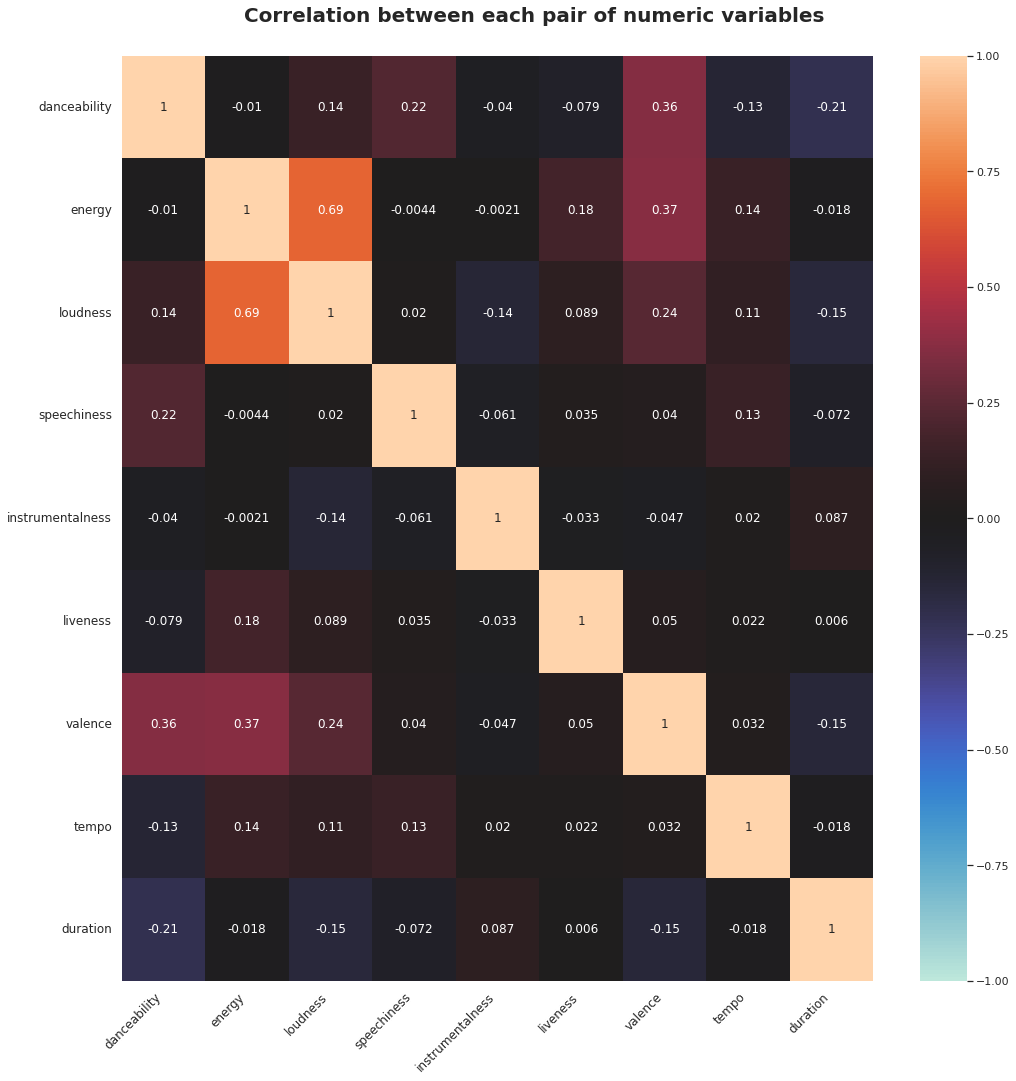

In [312]:
fig, ax = plt.subplots(figsize=(15, 15))
corr_df = df[num_feature].corr()
sns.heatmap(corr_df, annot=True, center=0, ax=ax, vmin=-1, vmax=1)
fig.suptitle("Correlation between each pair of numeric variables", fontsize=20, y=1, fontweight="bold")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right', fontsize=12)
fig.tight_layout()
save_plot("corr_pair_num_var", fig)

### Correlation between each numeric variable and playcount, view

#### For the whole dataset

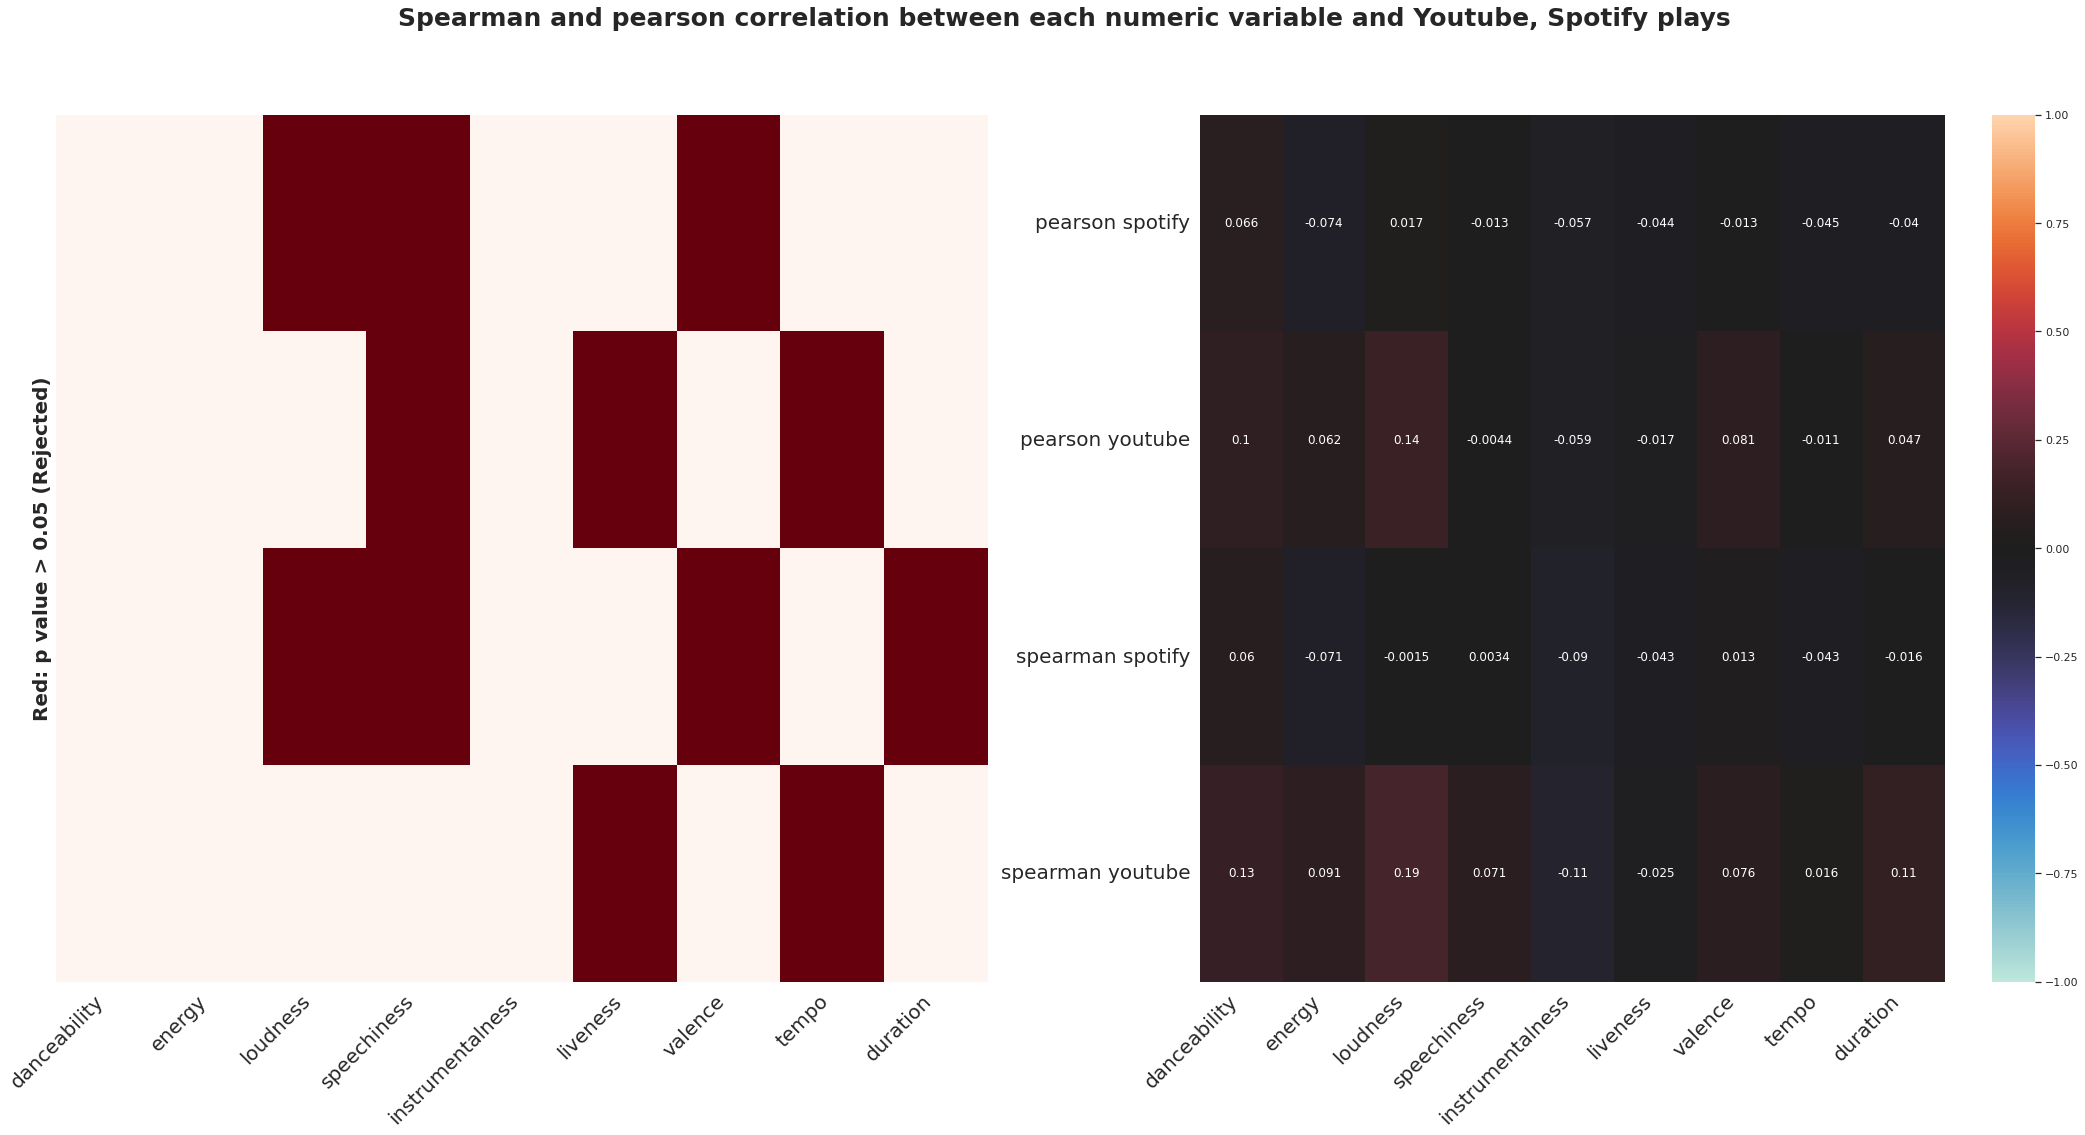

<Figure size 1440x1080 with 0 Axes>

In [195]:
fig, ax = plt.subplots(1, 2, figsize=(30, 15))
corr, p = get_corr_matrix(df, num_feature, p=True)
sns.heatmap(p, cmap="Reds", ax=ax[0], cbar=False, yticklabels=[])
ax[0].set_ylabel("Red: p value > 0.05 (Rejected)", fontsize=20, fontweight='bold')
fig.suptitle("Spearman and pearson correlation between each numeric variable and Youtube, Spotify plays", fontsize=25, fontweight='bold', y=1.05)
plt.figure(figsize=(20, 15))
sns.heatmap(corr, vmin=-1, vmax=1, annot=True, center=0, ax=ax[1], yticklabels=["pearson spotify", "pearson youtube", "spearman spotify", "spearman youtube"])
# ax[0].tick_params(labelsize=20, rotation=30)
# ax[1].tick_params('x', labelsize=20, rotation=30)
# ax[1].tick_params('y', labelsize=20, rotation=30)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right', fontsize=20)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='right', fontsize=20)
ax[1].set_ylabel("")
ax[1].tick_params('y', labelsize=20, rotation=0)
fig.tight_layout()
save_plot("corr", fig)

#### Joinplot

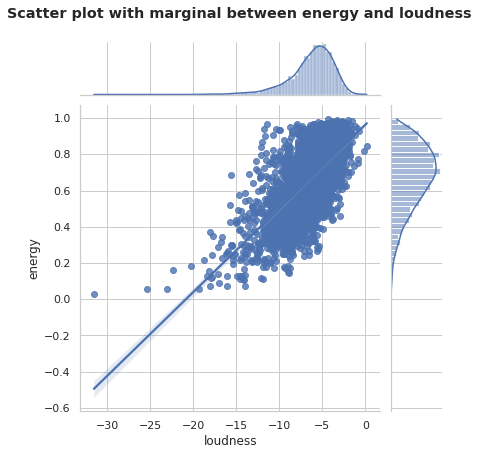

In [250]:
scat = sns.jointplot(data=df, x="loudness", y="energy", kind = 'reg')
plt.suptitle('Scatter plot with marginal between energy and loudness', y = 1.05, fontweight = 'bold')
save_plot("join_energy_loudness")

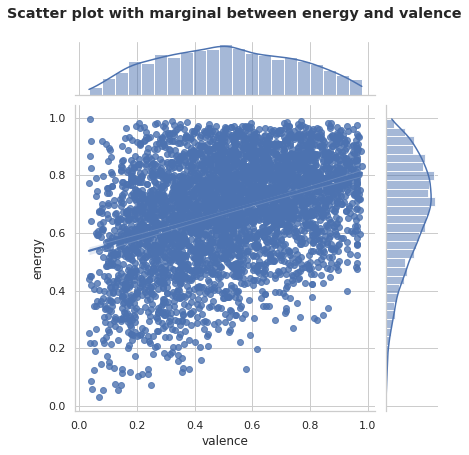

In [252]:
sns.jointplot(data=df, x="valence", y="energy", kind = 'reg')
plt.suptitle('Scatter plot with marginal between energy and valence', y = 1.05, fontweight = 'bold')
save_plot("join_energy_valence")

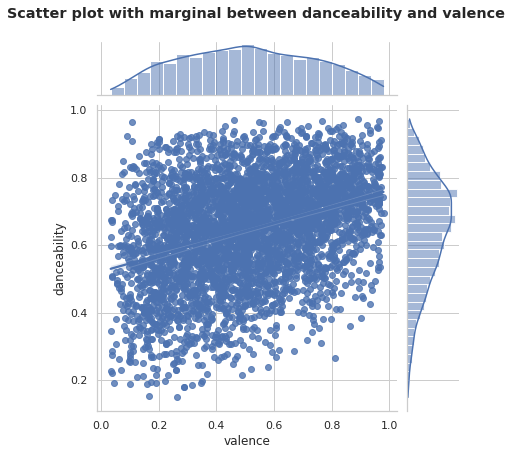

In [254]:
sns.jointplot(data=df, x="valence", y="danceability", kind = 'reg')
plt.suptitle('Scatter plot with marginal between danceability and valence', y = 1.05, fontweight = 'bold')
save_plot("join_dance_valence")

#### For each genre (dropped)

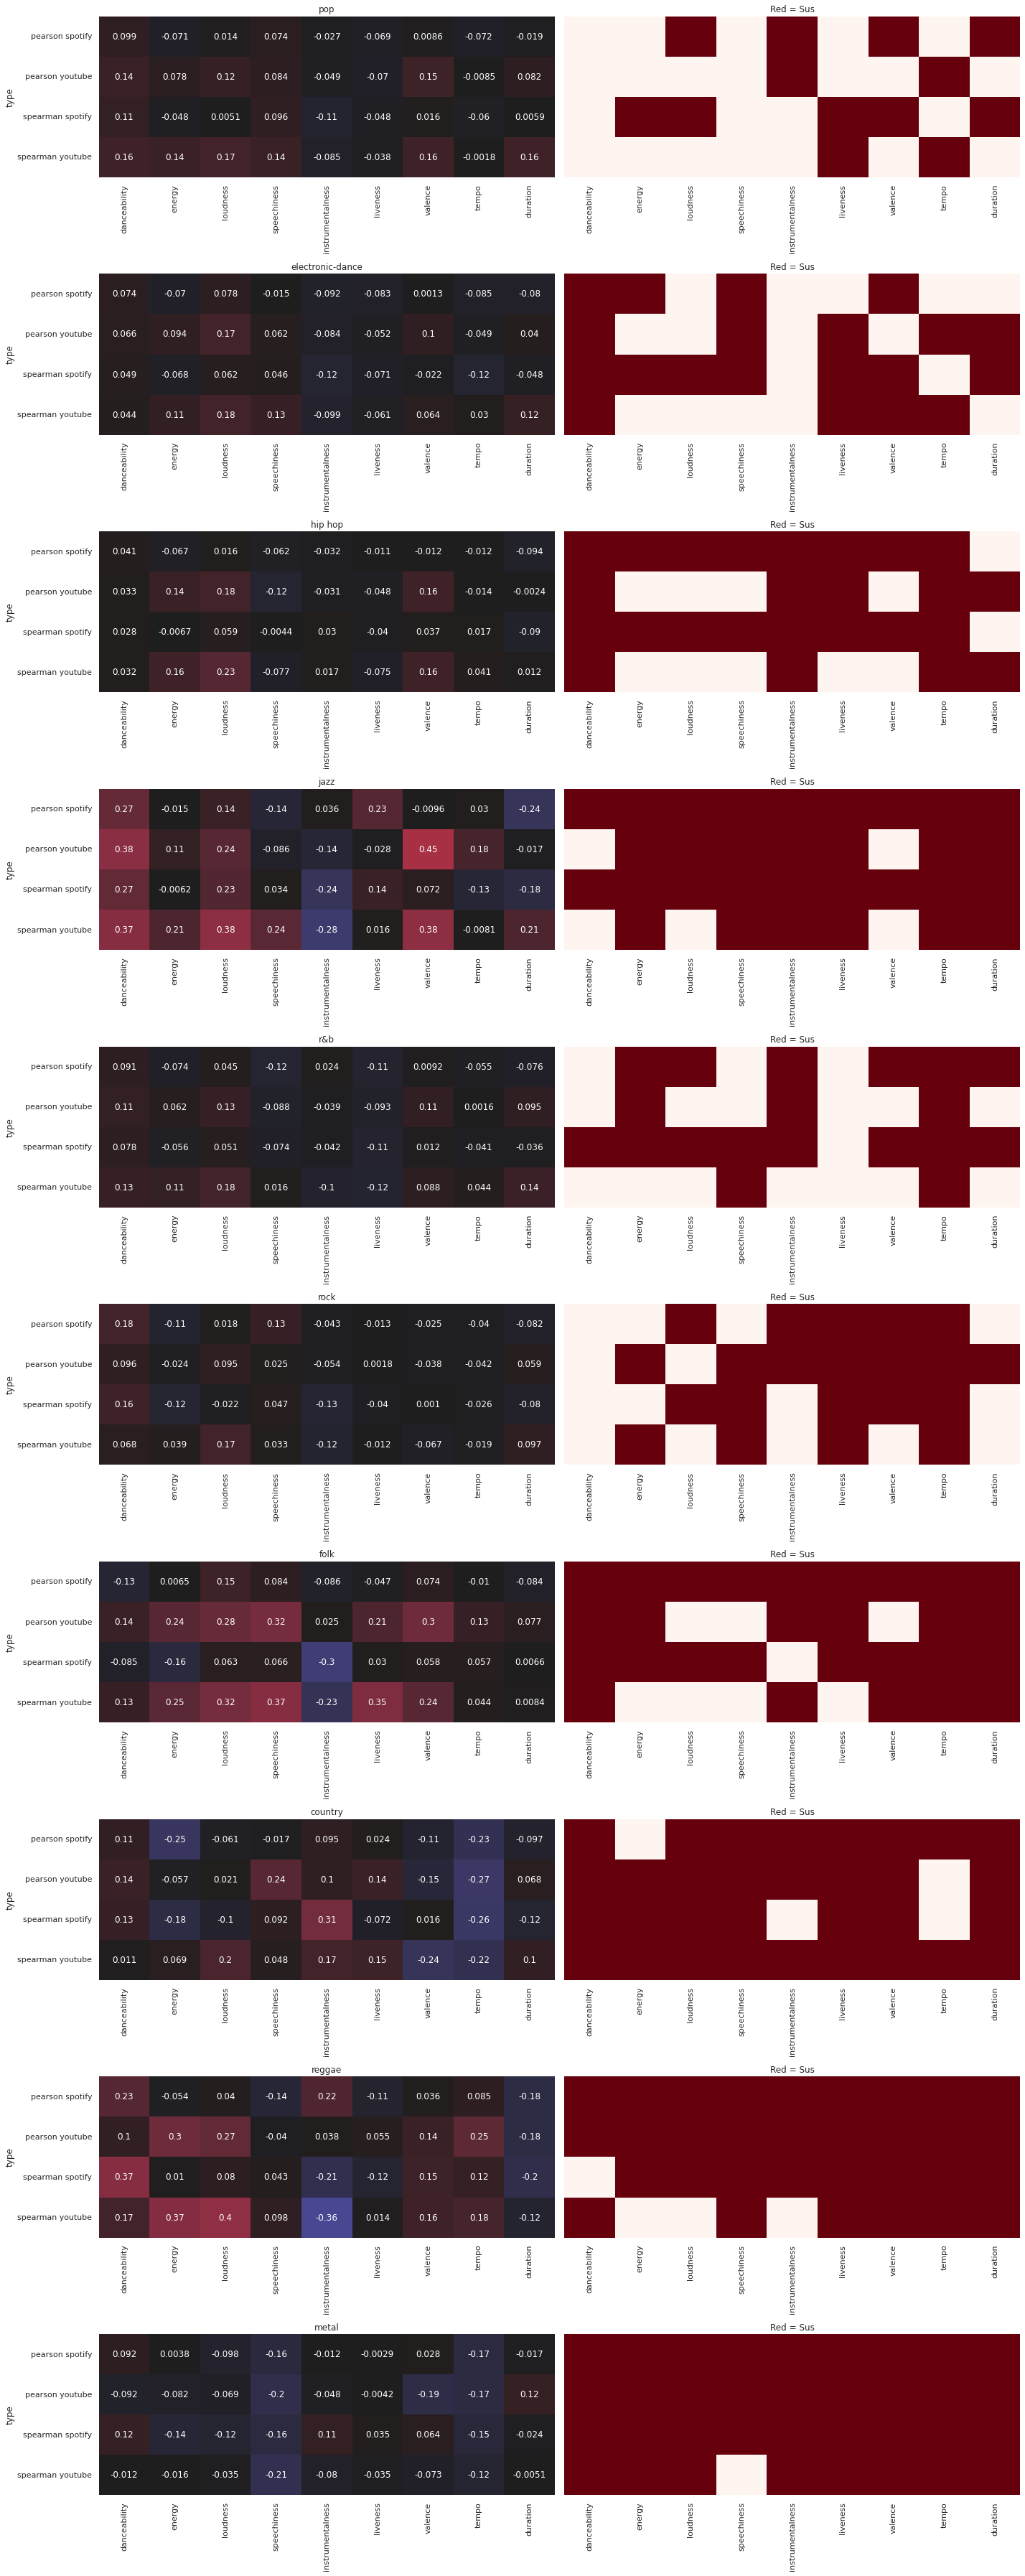

In [103]:
genres = df_with_genre["genres"].dropna().unique()
f, ax = plt.subplots(10, 2, figsize=(20, 50))
for i, genre in enumerate(genres):
    # col = i % 2
    # row = (i // 2) % 5
    corr, p = get_corr_matrix(
        df_with_genre[df_with_genre["genres"] == genre], num_feature, p=True)
    sns.heatmap(corr, vmin=-1, vmax=1, center=0,
                ax=ax[i, 0], cbar=False, annot=True, label=genre, yticklabels=["pearson spotify", "pearson youtube", "spearman spotify", "spearman youtube"])
    ax[i, 0].set_title(genre)
    sns.heatmap(p, cbar=False, ax=ax[i, 1], cmap="Reds", yticklabels=[])
    ax[i, 1].set_title("Red = Sus")
f.tight_layout()
save_plot("corr_genre", f)


### Plot distributrion and basic statistics

In [231]:
stat_dict = {}
for f in num_feature:
    stat_dict[f] = {}

for f in num_feature:
    mean = df[f].mean()
    stat_dict[f]['mean'] = mean
   # print(mean) 
    variance = df[f].var(axis=0)
    stat_dict[f]['std deviation'] = variance ** 0.5
    # print(variance)
    skewness = df[f].skew(axis=0)
    stat_dict[f]['skewness'] = skewness
    # print(skewness)
    kurtosis = df[f].kurt(axis=0)
    stat_dict[f]['kurtosis'] = kurtosis
    # print(kurtosis)

stat_dict

{'danceability': {'mean': 0.6449937980649963,
  'std deviation': 0.1520853838518928,
  'skewness': -0.42461244315294816,
  'kurtosis': -0.21066885503760924},
 'energy': {'mean': 0.6742189531133714,
  'std deviation': 0.17683165563533873,
  'skewness': -0.602677496210735,
  'kurtosis': 0.015866869754320057},
 'loudness': {'mean': -6.260403373852642,
  'std deviation': 2.623352417845704,
  'skewness': -1.56692616963624,
  'kurtosis': 5.468089686093316},
 'speechiness': {'mean': 0.09834825105432897,
  'std deviation': 0.09439861078641172,
  'skewness': 2.1392884847340525,
  'kurtosis': 5.173791085692594},
 'instrumentalness': {'mean': 0.020107707214090796,
  'std deviation': 0.10206279338761859,
  'skewness': 6.504849162886368,
  'kurtosis': 44.528516701327824},
 'liveness': {'mean': 0.17945460183577275,
  'std deviation': 0.14120151600502773,
  'skewness': 2.201588050692785,
  'kurtosis': 5.861135295388159},
 'valence': {'mean': 0.5111252790870752,
  'std deviation': 0.22832717854006074,

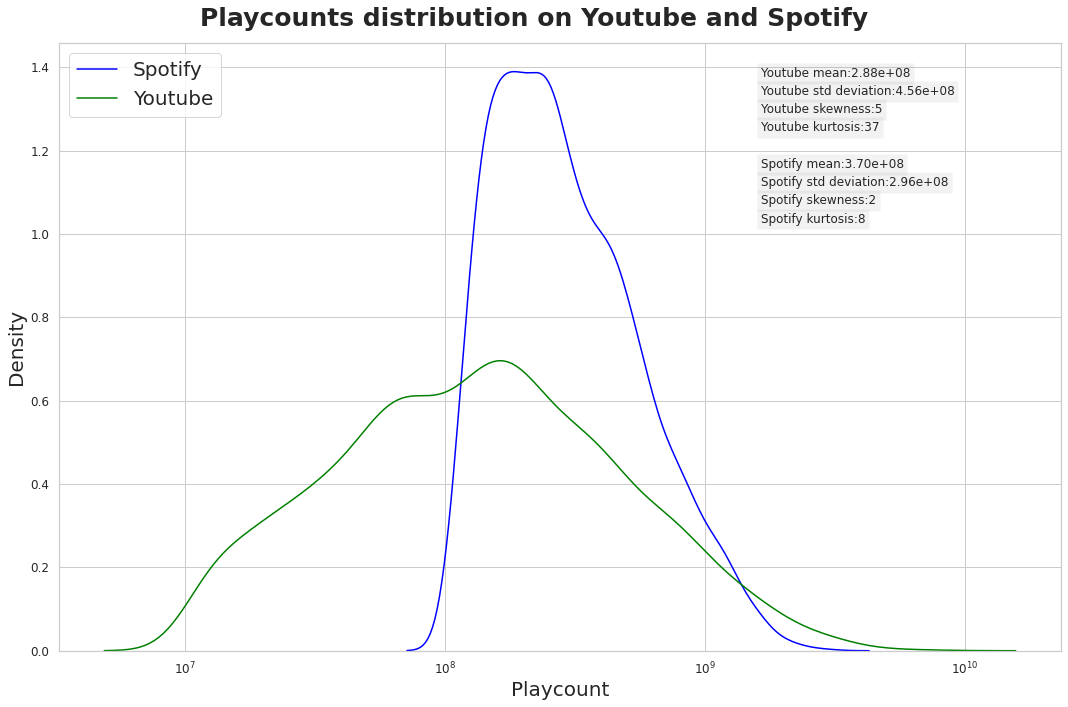

In [242]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.kdeplot(data=df, x="playcount", log_scale=True, ax=ax, color='blue', label="Spotify")
sns.kdeplot(data=df, x="view", log_scale=True, ax=ax, color='green', label="Youtube")
plt.legend(loc="upper left", prop={'size': 20})
ax.text(0.7, 0.95, 'Youtube {}:{:.2e}'.format("mean", df["view"].mean(axis=0)), size=12,
            verticalalignment='center', transform=ax.transAxes, bbox=dict(facecolor='grey', alpha=0.1))
ax.text(0.7, 0.92, 'Youtube {}:{:.2e}'.format("std deviation", df["view"].var(axis=0) ** 0.5), size=12,
            verticalalignment='center', transform=ax.transAxes, bbox=dict(facecolor='grey', alpha=0.1))
ax.text(0.7, 0.89, 'Youtube {}:{}'.format("skewness", round(df["view"].skew(axis=0))), size=12,
            verticalalignment='center', transform=ax.transAxes, bbox=dict(facecolor='grey', alpha=0.1))
ax.text(0.7, 0.86, 'Youtube {}:{}'.format("kurtosis", round(df["view"].kurt(axis=0))), size=12,
            verticalalignment='center', transform=ax.transAxes, bbox=dict(facecolor='grey', alpha=0.1))

ax.text(0.7, 0.80, 'Spotify {}:{:.2e}'.format("mean", df["playcount"].mean(axis=0)), size=12,
            verticalalignment='center', transform=ax.transAxes, bbox=dict(facecolor='grey', alpha=0.1))
ax.text(0.7, 0.77, 'Spotify {}:{:.2e}'.format("std deviation", df["playcount"].var(axis=0) ** 0.5), size=12,
            verticalalignment='center', transform=ax.transAxes, bbox=dict(facecolor='grey', alpha=0.1))
ax.text(0.7, 0.74, 'Spotify {}:{}'.format("skewness", round(df["playcount"].skew(axis=0))), size=12,
            verticalalignment='center', transform=ax.transAxes, bbox=dict(facecolor='grey', alpha=0.1))
ax.text(0.7, 0.71, 'Spotify {}:{}'.format("kurtosis", round(df["playcount"].kurt(axis=0))), size=12,
            verticalalignment='center', transform=ax.transAxes, bbox=dict(facecolor='grey', alpha=0.1))
ax.set_xlabel("Playcount")
fig.suptitle("Playcounts distribution on Youtube and Spotify", fontsize=25, fontweight="bold")
ax.tick_params(labelsize=12)
ax.set_xlabel("Playcount", size=20)
ax.set_ylabel("Density", size=20)
fig.tight_layout()
save_plot("play_dist", fig)

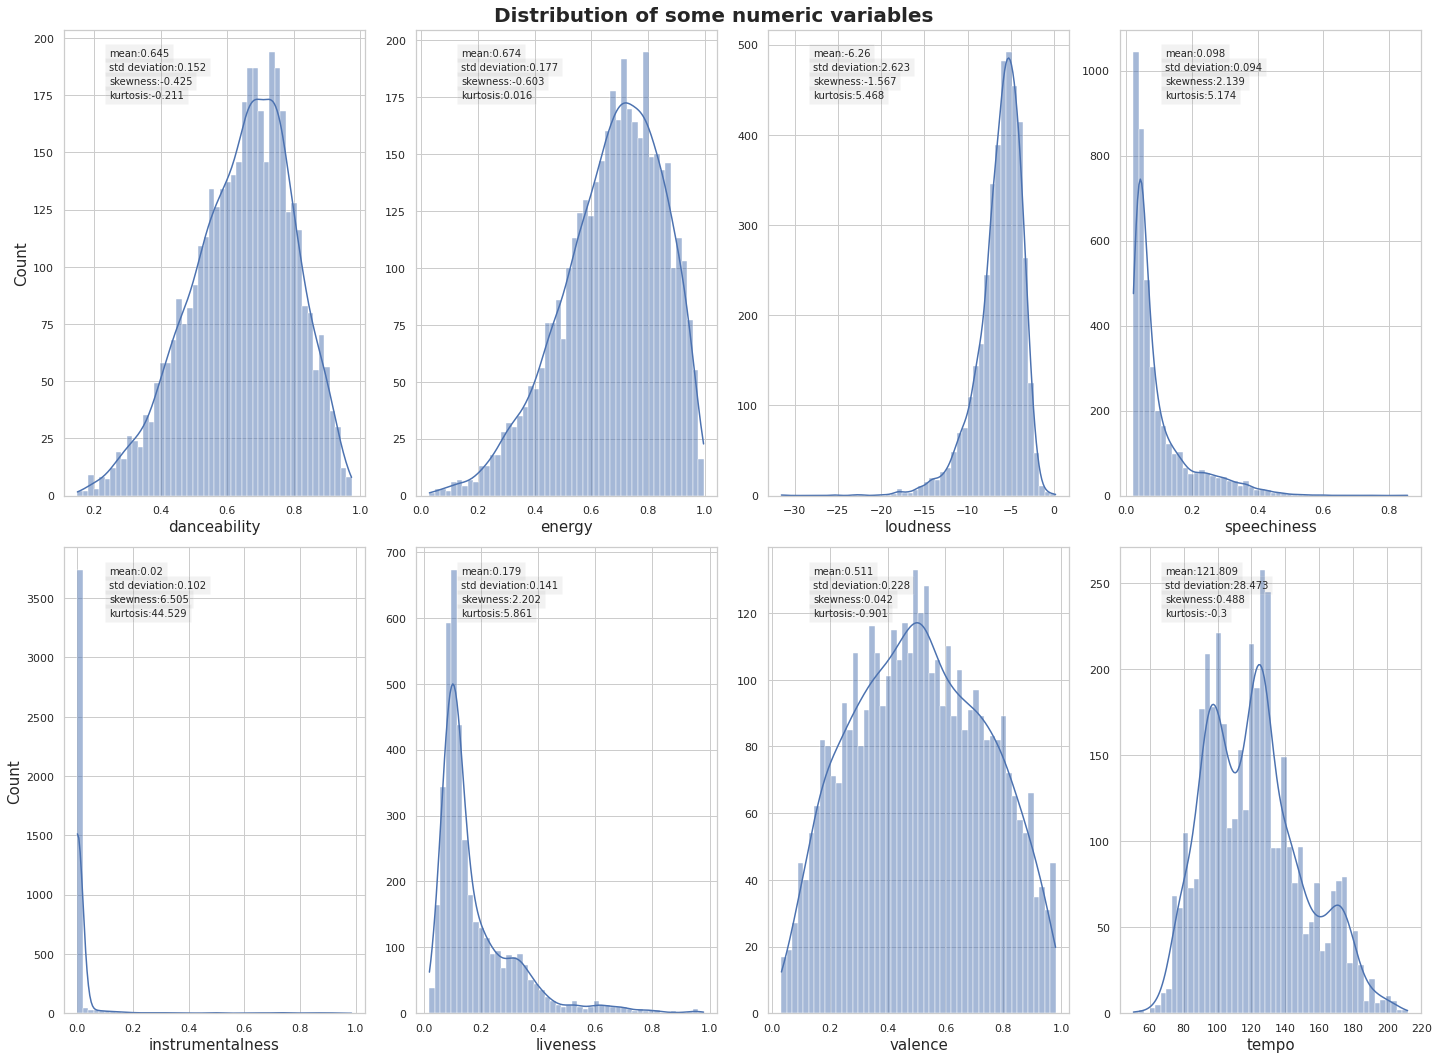

In [234]:
fig, ax = plt.subplots(2, 4, figsize=(20, 15))
for i in range(len(num_feature)):
    log_scale = False
    if num_feature[i] == "duration":
        continue
    # elif num_feature[i] == "instrumentalness":
    #     log_scale = True
    if i < 4:
        row = 0
    else:
        row = 1
    col = i % 4
    for j, key in enumerate(stat_dict[num_feature[i]].keys()):
        ax[row, col].text(0.15, 0.95 - j * 0.03, '{}:{}'.format(key, round(stat_dict[num_feature[i]][key], 3)), size=10,
                          verticalalignment='center', transform=ax[row, col].transAxes, bbox=dict(facecolor='grey', alpha=0.1))
    sns.histplot(data=df, x=num_feature[i], ax=ax[row, col], kde=True, bins=50, log_scale=log_scale)
    if col == 0:
        ax[row, col].set_ylabel(ax[row, col].get_ylabel(), fontsize=15)
    else:
        ax[row, col].set_ylabel("")
    ax[row, col].set_xlabel(ax[row, col].get_xlabel(), fontsize=15)
fig.suptitle("Distribution of some numeric variables", fontsize=20, fontweight="bold")
fig.tight_layout()
save_plot("num_var_dist", fig)


#### Duration distribution

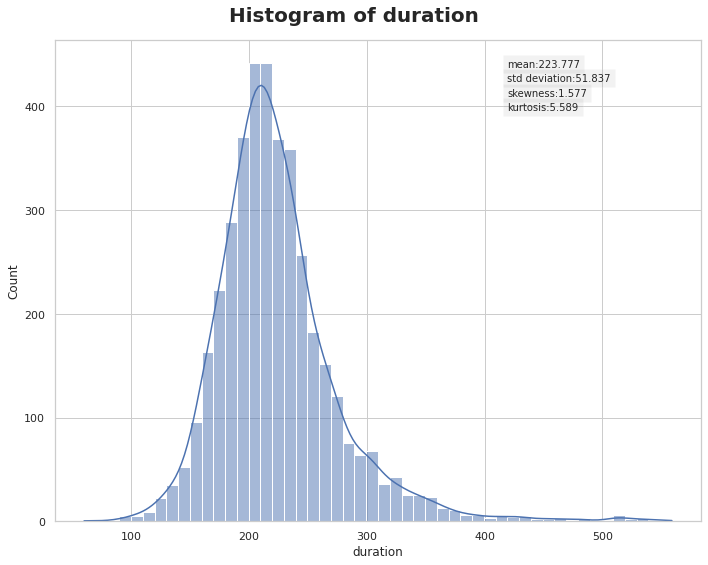

In [243]:
fig, ax = plt.subplots(figsize=(10,8))
sns.histplot(data=df, x="duration", kde=True, bins=50, ax=ax)
for j, key in enumerate(stat_dict["duration"].keys()):
    ax.text(0.7, 0.95 - j * 0.03, '{}:{}'.format(key, round(stat_dict["duration"][key], 3)), size=10,
            verticalalignment='center', transform=ax.transAxes, bbox=dict(facecolor='grey', alpha=0.1))
fig.suptitle("Histogram of duration", fontsize=20, fontweight="bold")
fig.tight_layout()
save_plot("dur_dist", fig)

### Correlation between playcount and view

In [244]:
print("Spearman: {:.2f}".format(df['playcount'].corr(df['view'], method='spearman')))
print("Pearson: {:.2f}".format(df['playcount'].corr(df['view'], method='pearson')))

Spearman: 0.56
Pearson: 0.58


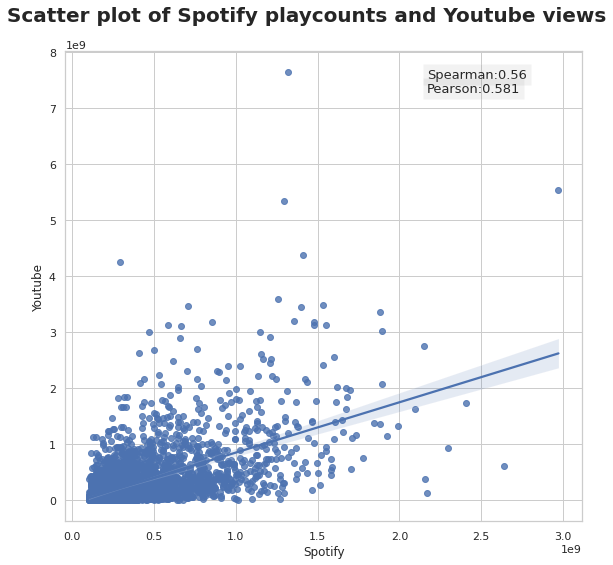

In [255]:
f, ax = plt.subplots(figsize=(8, 8))
sns.regplot(data=df, x="playcount", y="view", ax=ax)
ax.set_xlabel("Spotify")
ax.set_ylabel("Youtube")
f.suptitle("Scatter plot of Spotify playcounts and Youtube views", fontsize=20, fontweight="bold")
ax.text(0.7, 0.95, '{}:{}'.format("Spearman", round(df['playcount'].corr(df['view'], method='spearman'), 3)), size=13,
            verticalalignment='center', transform=ax.transAxes, bbox=dict(facecolor='grey', alpha=0.1))
ax.text(0.7, 0.92, '{}:{}'.format("Pearson", round(df['playcount'].corr(df['view'], method='pearson'), 3)), size=13,
            verticalalignment='center', transform=ax.transAxes, bbox=dict(facecolor='grey', alpha=0.1))
f.tight_layout()
save_plot("play_scat", f)

### Counts of each mode with different playcount bins

#### Shitty population pyramid (dropped)

In [110]:
bins = pd.IntervalIndex.from_tuples(
    [(0, 2e8), (2e8, 3e8), (3e8, 4e8), (4e8, 5e8), (5e8, 7.5e8), (7.5e8, 1e9), (1e9, 3e9)])
df_pyra = df.copy()
df_pyra["bins"] = pd.cut(df_pyra["playcount"], bins)

In [111]:
pop_dist_0 = df_pyra[df_pyra["mode"] == "minor"].groupby("bins")[["playcount"]].count()
pop_dist_1 = df_pyra[df_pyra["mode"] == "major"].groupby("bins")[["playcount"]].count()
pop_dist = pd.DataFrame()
pop_dist["major"] = pop_dist_0['playcount']
pop_dist["minor"] = pop_dist_1['playcount'].apply(lambda x: 0 - x)
pop_dist = pop_dist.reset_index()


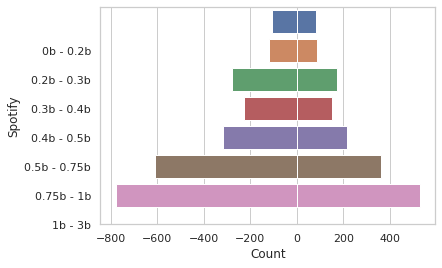

In [112]:
sns.barplot(x="major", y="bins", data=pop_dist, order=bins[::-1])
sns.barplot(x="minor", y="bins", data=pop_dist, order=bins[::-1])
plt.xlabel("bruh")
group_name = [
    "0b - 0.2b",
    "0.2b - 0.3b",
    "0.3b - 0.4b",
    "0.4b - 0.5b",
    "0.5b - 0.75b",
    "0.75b - 1b",
    "1b - 3b"
]
my_range = range(1, len(pop_dist.index)+1)
plt.yticks(my_range, group_name)
plt.xlabel('Count')
plt.ylabel('Spotify')
save_plot("pyramid")

#### Epic lollipop plot

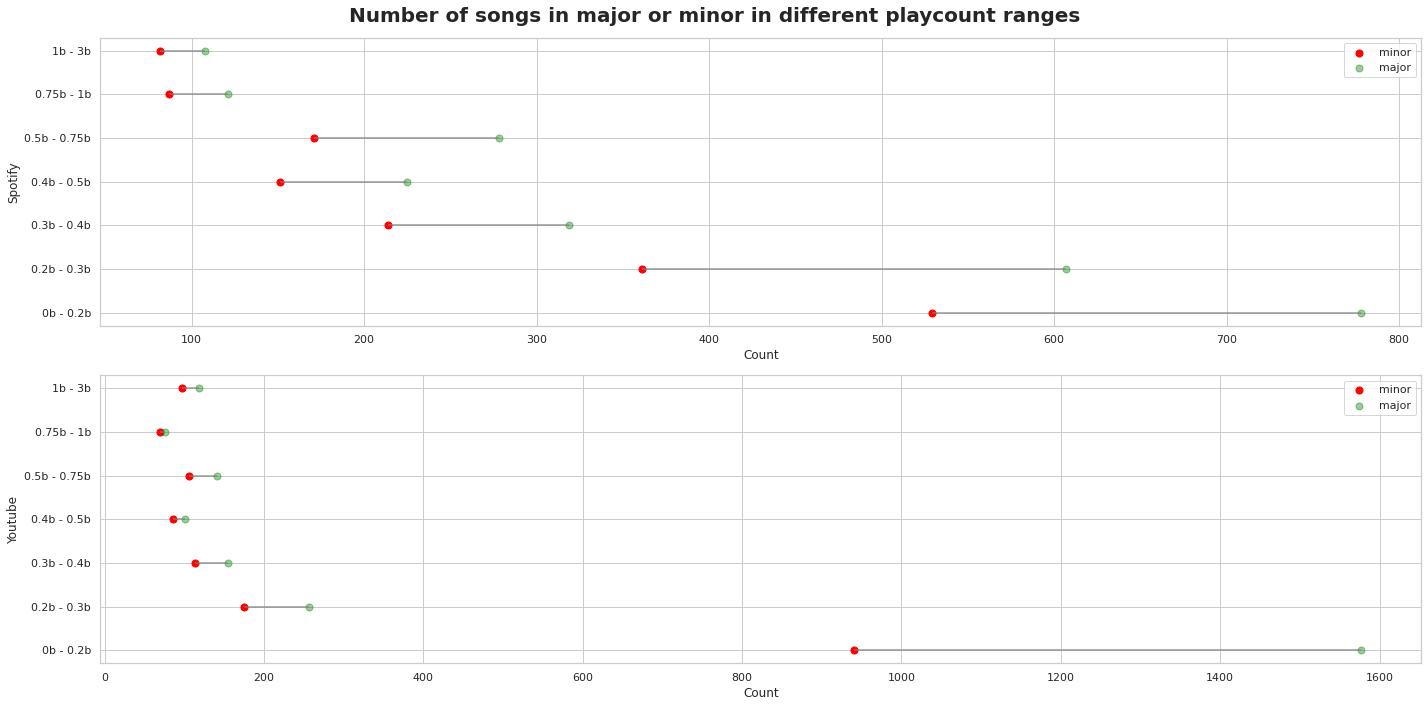

In [269]:
bins = pd.IntervalIndex.from_tuples(
    [(0, 2e8), (2e8, 3e8), (3e8, 4e8), (4e8, 5e8), (5e8, 7.5e8), (7.5e8, 1e9), (1e9, 3e9)])
def plot_lollipop(pop_type, ax):
    df_lolli = df.copy()
    df_lolli["bins"] = pd.cut(df_lolli[pop_type], bins)
    pop_dist_0 = df_lolli[df_lolli["mode"] == "minor"].groupby("bins")[[pop_type]].count()
    pop_dist_1 = df_lolli[df_lolli["mode"] == "major"].groupby("bins")[[pop_type]].count()
    pop_dist = pd.DataFrame()
    pop_dist["minor"] = pop_dist_0[pop_type]
    pop_dist["major"] = pop_dist_1[pop_type]
    pop_dist = pop_dist.reset_index()
    my_range = range(1, len(pop_dist.index)+1)

    # The horizontal plot is made using the hline function
    ax.hlines(y=my_range, xmin=pop_dist['minor'],
            xmax=pop_dist['major'], color='grey', alpha=0.6, lw=2)
    ax.scatter(pop_dist['minor'], my_range,
                color='red', alpha=1, label='minor', s=50)
    ax.scatter(pop_dist['major'], my_range,
                color='green', alpha=0.4, label='major', s=50)
    ax.legend()

    # Add title and axis names
    group_name = [
        "0b - 0.2b",
        "0.2b - 0.3b",
        "0.3b - 0.4b",
        "0.4b - 0.5b",
        "0.5b - 0.75b",
        "0.75b - 1b",
        "1b - 3b"
    ]
    ax.set_yticks(my_range, group_name)
    ax.set_xlabel('Count')
    if pop_type == "playcount":
        ax.set_ylabel('Spotify')
    elif pop_type == "view":
        ax.set_ylabel('Youtube')

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
plot_lollipop("playcount", ax[0])
plot_lollipop("view", ax[1])
fig.suptitle("Number of songs in major or minor in different playcount ranges", fontsize=20, fontweight='bold')
# Show the graph
fig.tight_layout()
save_plot("lollipop")

### Scatter plot of view and playcount corresponding to the "explicit" variable

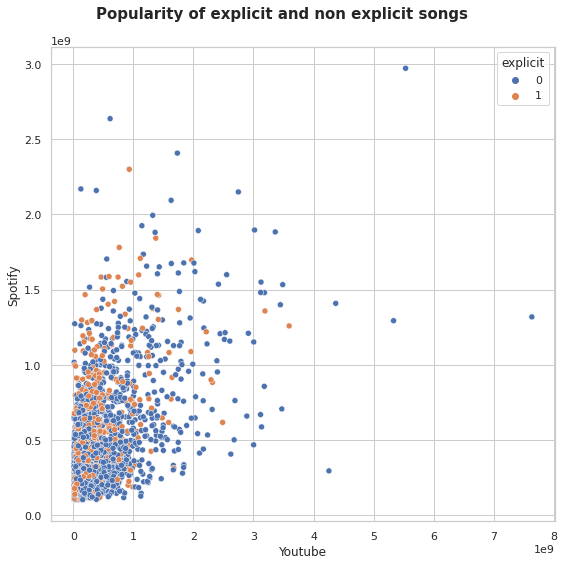

In [272]:
f, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=df, x="view", y="playcount", hue='explicit', ax=ax)
ax.set_ylabel("Spotify")
ax.set_xlabel("Youtube")
f.suptitle("Popularity of explicit and non explicit songs", fontsize=15, fontweight='bold')
f.tight_layout()
save_plot("play_explicit_scat", f)

### Strip plot of the playcount and view of each key

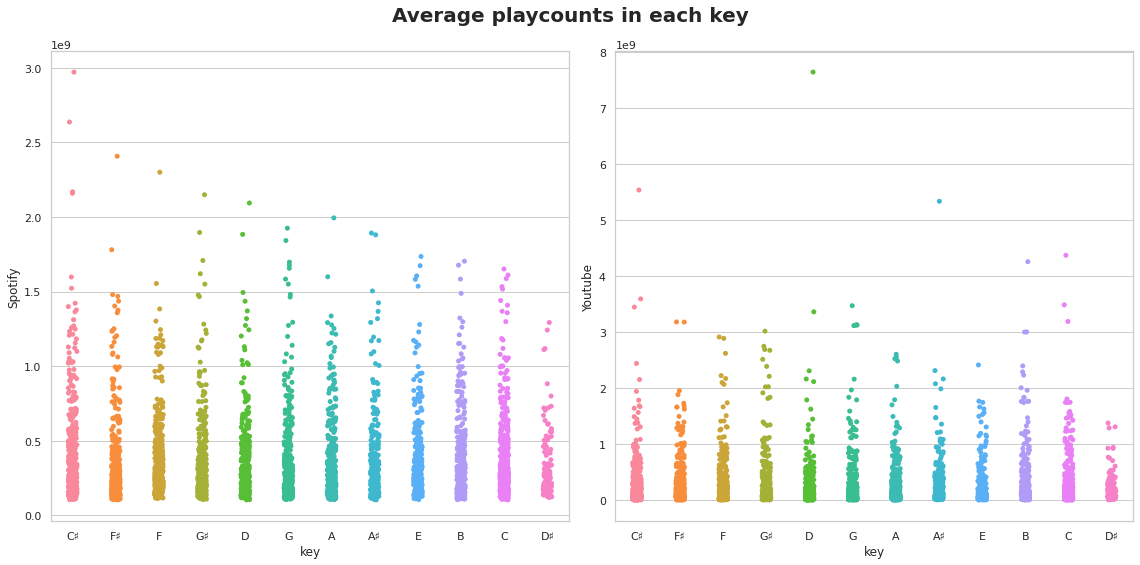

In [273]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
sns.stripplot(x="key", y="playcount", data=df, ax=ax[0])
sns.stripplot(x="key", y="view", data=df, ax=ax[1])
ax[0].set_ylabel("Spotify")
ax[1].set_ylabel("Youtube")
fig.suptitle("Average playcounts in each key", fontsize=20, fontweight='bold')
fig.tight_layout()
save_plot("play_strip", fig)

### Bar plot of the counts of each categorical variable

#### Explicit

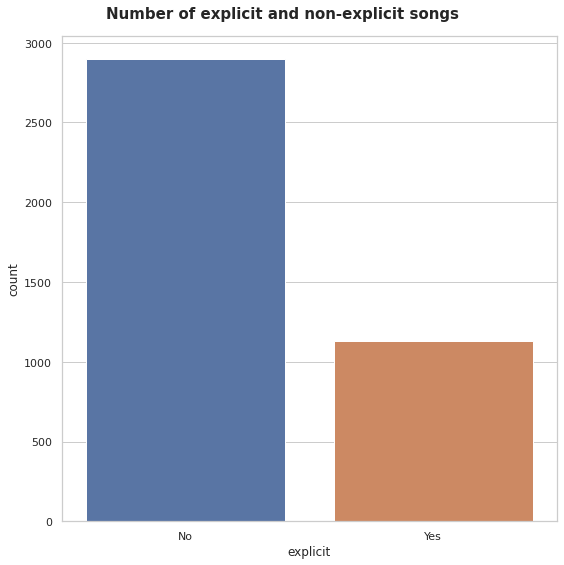

In [288]:
plt.figure(figsize=(8,8))
sns.countplot(x="explicit", data=df, order=df['explicit'].value_counts().index)
plt.suptitle("Number of explicit and non-explicit songs", fontsize=15, fontweight='bold')
plt.xticks([0, 1], ['No', 'Yes'])
plt.tight_layout()
save_plot("explicit_count")

#### Key

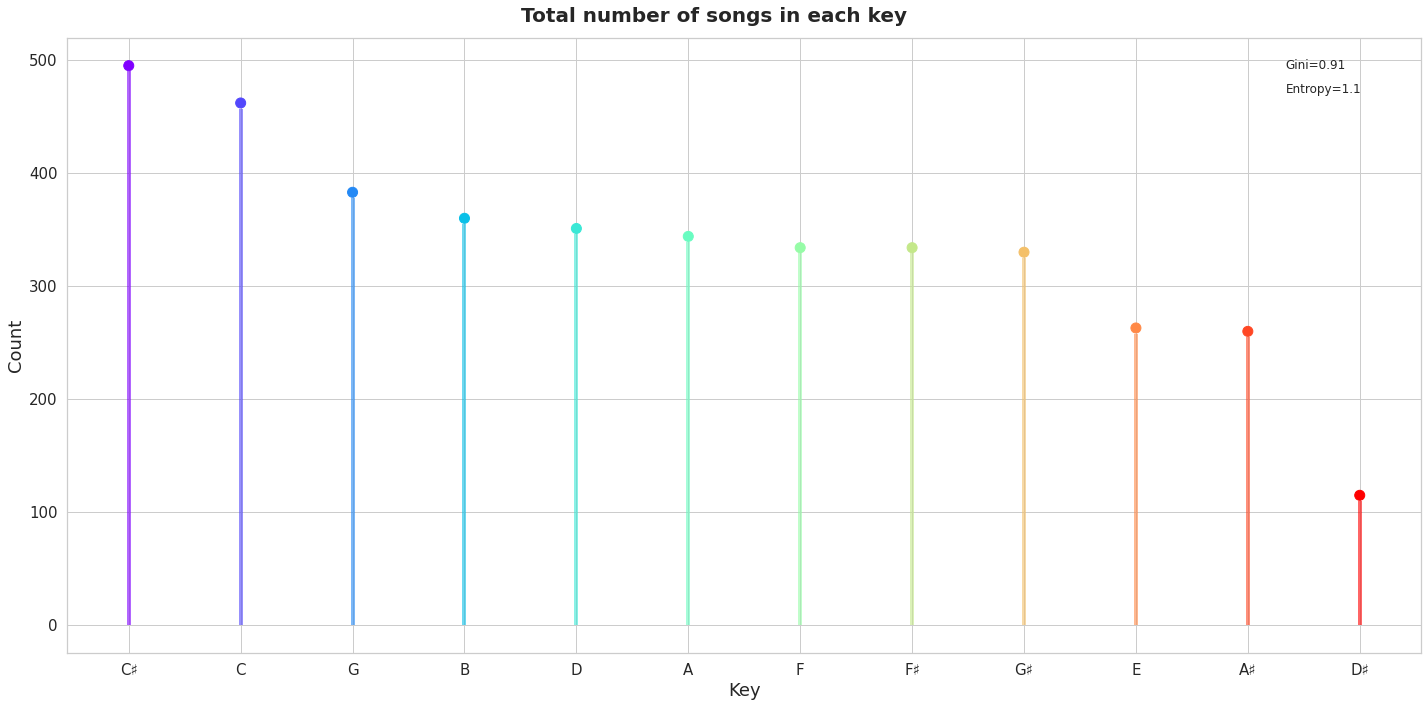

In [284]:
# sns.countplot(x="key", data=df, order=df['key'].value_counts().index)
fig, ax = plt.subplots(figsize=(20, 10))
key_count = df['key'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(key_count)))
my_range = np.arange(len(key_count))
ax.vlines(x=my_range, ymin=0, ymax=key_count - 5,
          alpha=0.6, linewidth=4, colors=colors)
ax.scatter(x=my_range, y=key_count, s=100, c=colors)
ax.set_xticks(my_range, key_count.index)
ax.text(0.9, 0.95, 'Gini={}'.format(
    round(gini(df, 'key'), 2)), transform=ax.transAxes)
ax.text(0.9, 0.91, 'Entropy={}'.format(
    round(entropy(df, 'key'), 2)), transform=ax.transAxes)
fig.suptitle("Total number of songs in each key", fontsize=20, fontweight="bold")
ax.tick_params(labelsize=15)
ax.set_xlabel("Key", fontsize=18)
ax.set_ylabel("Count", fontsize=18)
fig.tight_layout()
save_plot("key_lolli", fig)


#### Time signature

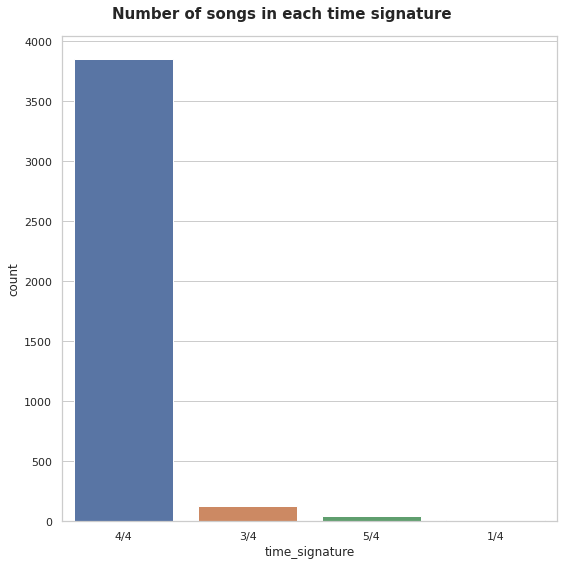

In [289]:
plt.figure(figsize=(8,8))
sns.countplot(x="time_signature", data=df,
              order=df['time_signature'].value_counts().index)
plt.suptitle("Number of songs in each time signature", fontsize=15, fontweight='bold')
plt.tight_layout()
save_plot("time_sig_count")

#### Mode

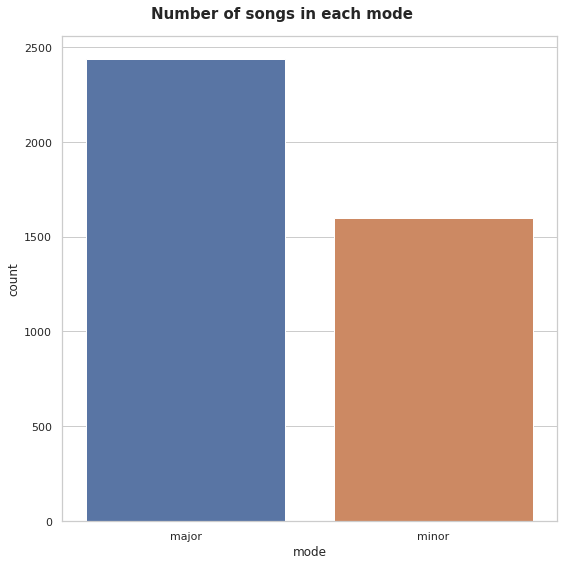

In [290]:
plt.figure(figsize=(8,8))
sns.countplot(x="mode", data=df, order=df['mode'].value_counts().index)
plt.suptitle("Number of songs in each mode", fontsize=15, fontweight='bold')
plt.tight_layout()
save_plot("mode_count")

### Artists with the highest number of hits

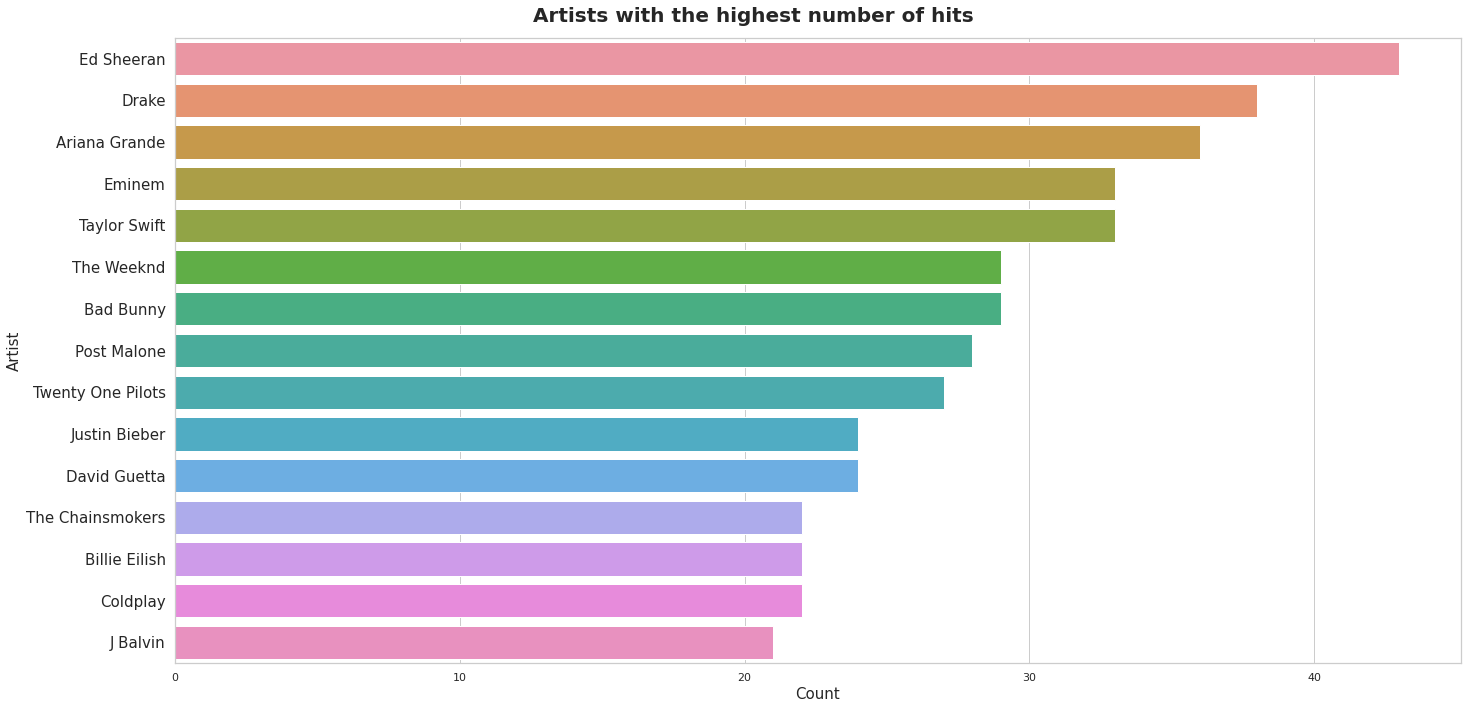

In [293]:
plt.figure(figsize=(20, 10))
df_no_various_artist = df[df["artist"] != "Various Artists"]
# artist_count = df_no_various_artist["artist"].value_counts().reset_index()
# num_artist = 15
# plt.hlines(y=range(num_artist), xmin=0, xmax=artist_count["artist"][:num_artist], color='grey', alpha=0.4)
# plt.scatter(y=range(num_artist), x=artist_count["artist"][:num_artist], s=200, alpha=0.8)
# plt.xticks(range())
sns.countplot(y="artist", data=df_no_various_artist,
              order=df_no_various_artist['artist'].value_counts().index[0:15])
plt.suptitle("Artists with the highest number of hits", fontsize=20, fontweight="bold")
plt.tight_layout()
plt.xlabel("Count", fontsize=15)
plt.ylabel("Artist", fontsize=15)
plt.yticks(fontsize=15)
save_plot("most_pop_artist")

#### Circular bar plot of the artists with the highest mean playcounts with respect to each genre

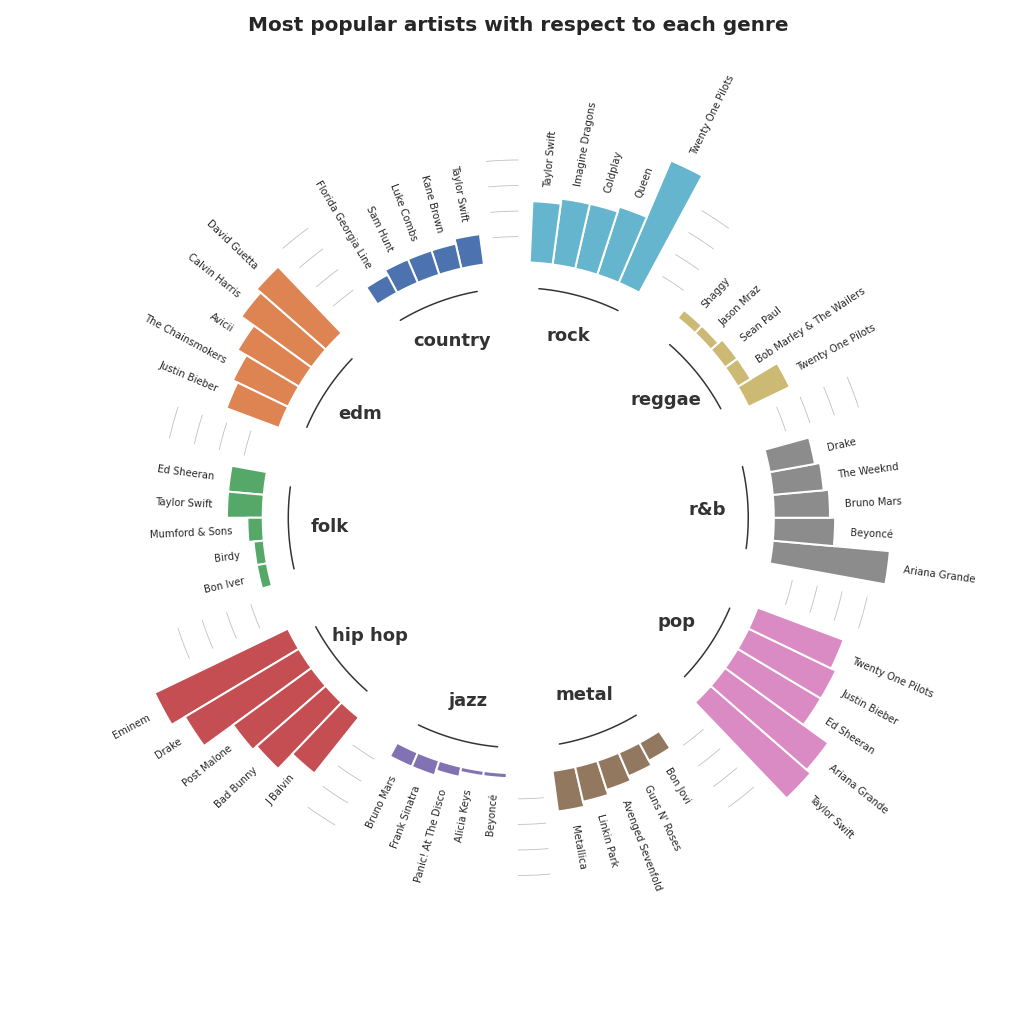

In [315]:
df_genre_sub = df_with_genre[['artist', 'playcount', 'genres']]
df_genre_sub.head()
cir_plot = df_genre_sub.groupby(['genres', 'artist'])[['playcount']].count().reset_index()
cir_plot = cir_plot.set_index('artist').groupby(['genres'])['playcount'].nlargest(5).reset_index()

# Grab the group values
GROUP = cir_plot["genres"].values
VALUES = cir_plot["playcount"].values
LABELS = cir_plot["artist"].values

# Add three empty bars to the end of each group
PAD = 2
ANGLES_N = len(VALUES) + PAD * len(np.unique(GROUP))
ANGLES = np.linspace(0, 2 * np.pi, num=ANGLES_N, endpoint=False)
WIDTH = (2 * np.pi) / len(ANGLES)
OFFSET = np.pi / 2

# Obtaining the right indexes is now a little more complicated
offset = 0
IDXS = []
GROUPS_SIZE = [5 for i in range(10)]
for size in GROUPS_SIZE:
    IDXS += list(range(offset + PAD, offset + size + PAD))
    offset += size + PAD
# Same layout as above
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw={"projection": "polar"})

ax.set_theta_offset(OFFSET)
ax.set_ylim(-50, 50)
ax.set_frame_on(False)
ax.xaxis.grid(False)
ax.yaxis.grid(False)
ax.set_xticks([])
ax.set_yticks([])

# Use different colors for each group!
COLORS = [f"C{i}" for i, size in enumerate(GROUPS_SIZE) for _ in range(size)]

# And finally add the bars. 
# Note again the `ANGLES[IDXS]` to drop some angles that leave the space between bars.
ax.bar(
    ANGLES[IDXS], VALUES, width=WIDTH, color=COLORS, 
    edgecolor="white", linewidth=2
)

add_labels(ANGLES[IDXS], VALUES, LABELS, OFFSET, ax)

offset = 0 
for group, size in zip(cir_plot["genres"].unique(), GROUPS_SIZE):
    # Add line below bars
    x1 = np.linspace(ANGLES[offset + PAD], ANGLES[offset + size + PAD - 1], num=50)
    ax.plot(x1, [-5] * 50, color="#333333")
    
    # Add text to indicate group
    ax.text(
        np.mean(x1), -13, group, color="#333333", fontsize=18, 
        fontweight="bold", ha="center", va="center"
    )
    
    # Add reference lines at 20, 40, 60, and 80
    x2 = np.linspace(ANGLES[offset], ANGLES[offset + PAD - 1], num=50)
    ax.plot(x2, [5] * 50, color="#bebebe", lw=0.8)
    ax.plot(x2, [10] * 50, color="#bebebe", lw=0.8)
    ax.plot(x2, [15] * 50, color="#bebebe", lw=0.8)
    ax.plot(x2, [20] * 50, color="#bebebe", lw=0.8)
    
    offset += size + PAD
fig.suptitle("Most popular artists with respect to each genre", fontsize=20, fontweight="bold", y=0.95)
fig.tight_layout()
save_plot("cir_bar", fig)

### Genre

#### The count of each genre

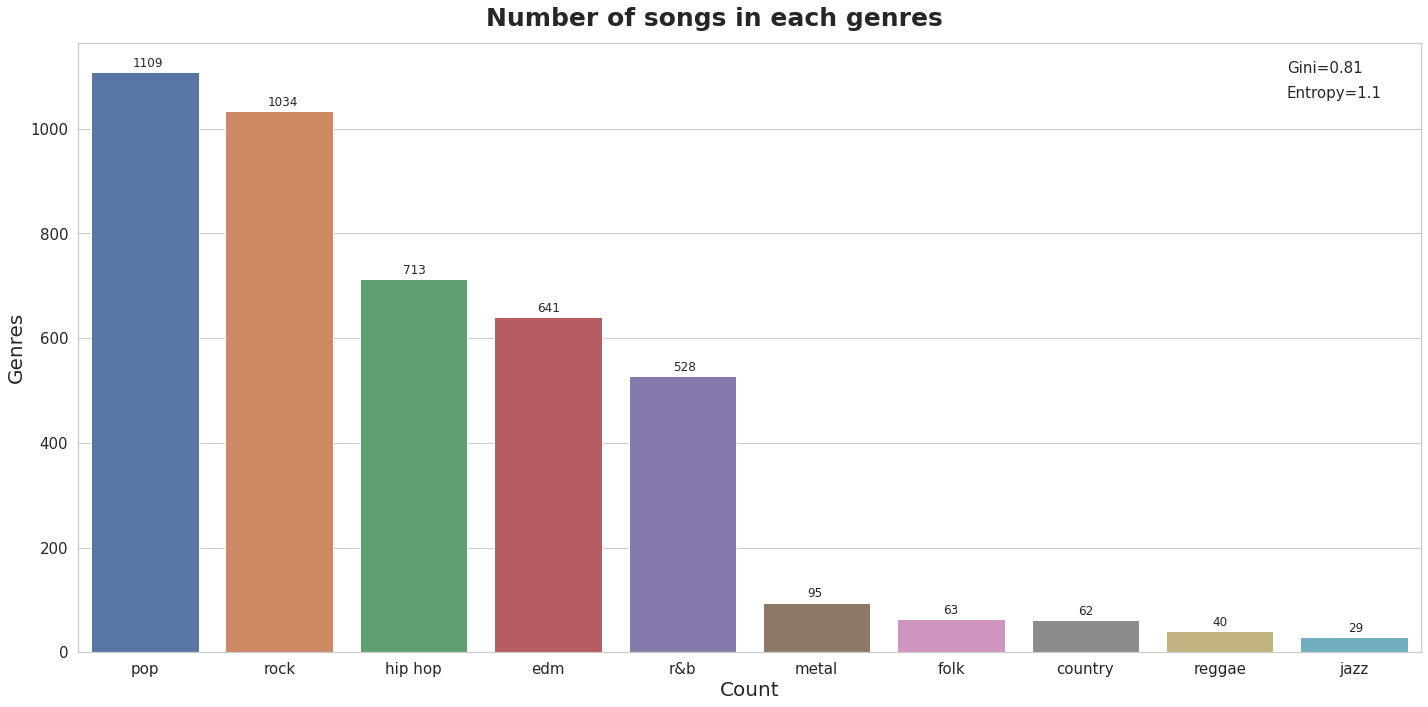

In [342]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.countplot(x="genres", data=df_with_genre,
              order=df_with_genre['genres'].value_counts(dropna=True).index, ax=ax)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() *
                1.005 + 0.31, p.get_height() + 10))
fig.suptitle("Number of songs in each genres", fontsize=25, fontweight="bold")
ax.text(0.9, 0.95, 'Gini={}'.format(
    round(gini(df_with_genre, 'genres'), 2)), transform=ax.transAxes, size=15)
ax.text(0.9, 0.91, 'Entropy={}'.format(
    round(entropy(df_with_genre, 'genres'), 2)), transform=ax.transAxes, size=15)
ax.set_ylabel("Genres", fontsize=20)
ax.set_xlabel("Count", fontsize=20)
ax.tick_params(labelsize=15)
fig.tight_layout()
save_plot("genre_count", fig)

#### Playcount and view distribution with respect to each genre

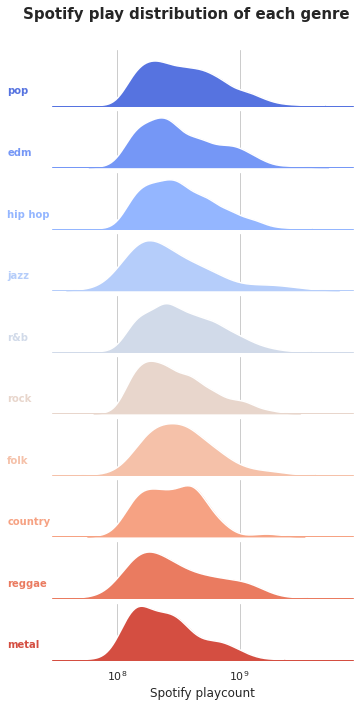

In [347]:
# cmap = cm.get_cmap('viridis')
# d = {'color': [cmap(i) for i in np.linspace(0, 1, 10)]}
pal = sns.color_palette(palette='coolwarm', n_colors=10)
ridge_plot = sns.FacetGrid(df_with_genre, row="genres", hue="genres",
                           aspect=5, height=1, palette=pal)
fig = ridge_plot.figure
fig.suptitle("Spotify play distribution of each genre", fontsize=15, fontweight='bold')
ridge_plot.map(sns.kdeplot, 'playcount', clip_on=False,
               fill=True, alpha=1, lw=1, log_scale=True, bw_adjust=1)
ridge_plot.map(sns.kdeplot, 'playcount', 
      bw_adjust=1, clip_on=False, 
      color="w", lw=1.5)
ridge_plot.map(plt.axhline, y=0, lw=1, clip_on=False)
ridge_plot.fig.subplots_adjust(hspace=0.1)
ridge_plot.set(yticks=[])
ridge_plot.set(title="")
ridge_plot.set_ylabels("")
ridge_plot.set_xlabels("Spotify playcount")
ridge_plot.despine(bottom=True, left=True)
for ax, genre in zip(ridge_plot.axes.flat, df_with_genre["genres"].dropna().unique()):
    ax.text(-0.15, 0.2, genre,
            fontweight='bold', fontsize=10,
            color=ax.lines[-1].get_color(), transform=ax.transAxes)
# fig.tight_layout()
save_plot("playcount_dist_genre", fig)

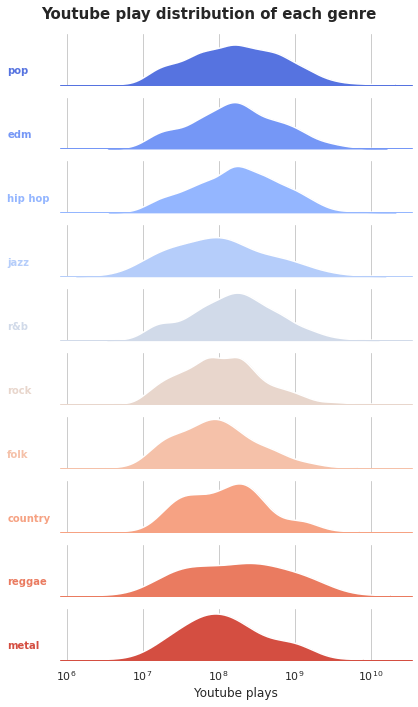

In [348]:
# cmap = cm.get_cmap('viridis')
# d = {'color': [cmap(i) for i in np.linspace(0, 1, 10)]}
pal = sns.color_palette(palette='coolwarm', n_colors=10)
ridge_plot = sns.FacetGrid(df_with_genre, row="genres", hue="genres",
                           aspect=6, height=1, palette=pal)
fig = ridge_plot.figure
fig.suptitle("Youtube play distribution of each genre", fontsize=15, fontweight='bold')
ridge_plot.map(sns.kdeplot, 'view', clip_on=False,
               fill=True, alpha=1, lw=1, log_scale=True, bw_adjust=1)
ridge_plot.map(sns.kdeplot, 'view', 
      bw_adjust=1, clip_on=False, 
      color="w", lw=1.5)
ridge_plot.map(plt.axhline, y=0, lw=1, clip_on=False)
ridge_plot.fig.subplots_adjust(hspace=0.1)
ridge_plot.set(yticks=[])
ridge_plot.set_ylabels("")
ridge_plot.set_xlabels("Youtube plays")
ridge_plot.set(title="")
ridge_plot.despine(bottom=True, left=True)
for ax, genre in zip(ridge_plot.axes.flat, df_with_genre["genres"].dropna().unique()):
    ax.text(-0.15, 0.2, genre,
            fontweight='bold', fontsize=10,
            color=ax.lines[-1].get_color(), transform=ax.transAxes)
fig.tight_layout()
save_plot("view_dist_genre", fig)

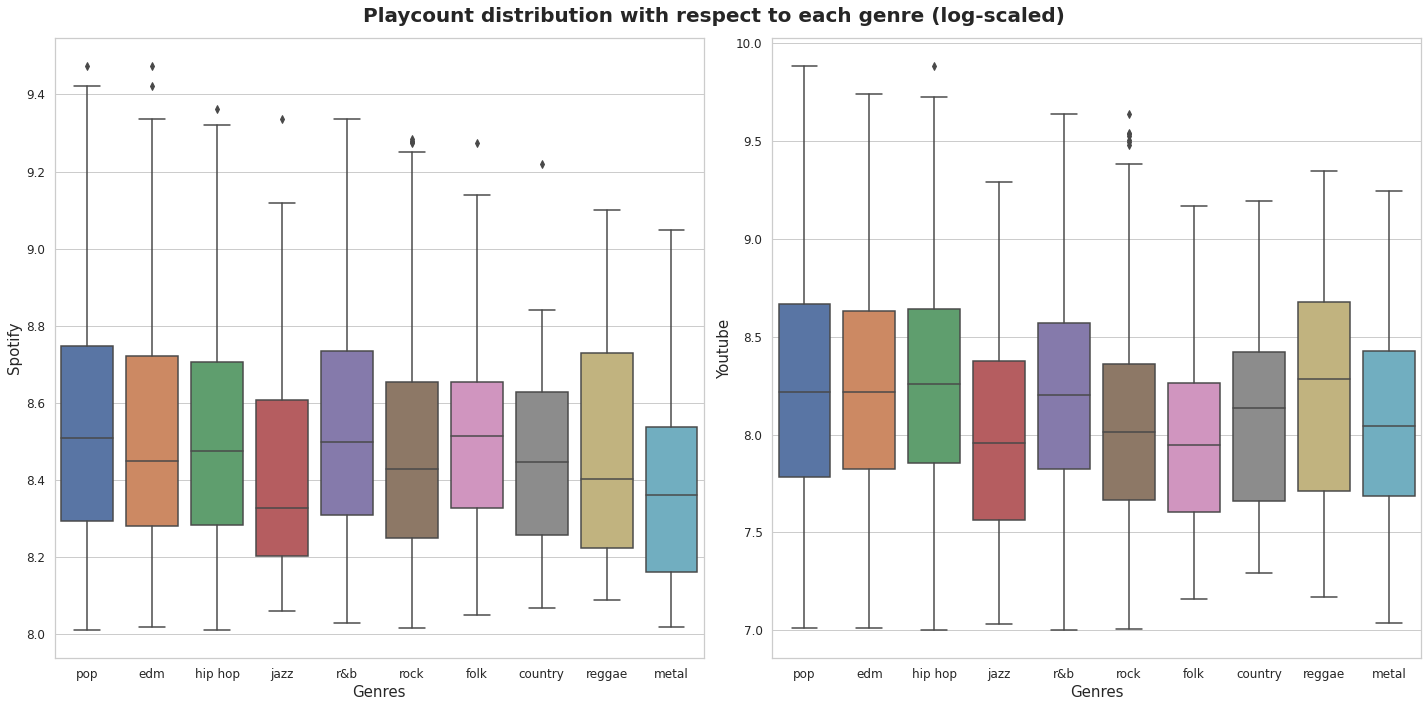

In [390]:
fig, ax = plt.subplots(1,2, figsize = (20,10))
df_log = df_with_genre.copy()
df_log["playcount"] = df_log["playcount"].apply(log10)
df_log["view"] = df_log["view"].apply(log10)
sns.boxplot(x="genres", y="playcount", data=df_log, ax = ax[0])
sns.boxplot(x="genres", y="view", data=df_log, ax = ax[1])
fig.suptitle("Playcount distribution with respect to each genre (log-scaled)", fontsize=20, fontweight='bold')
for a in ax:
    ylabel = a.get_ylabel()
    if ylabel == 'playcount':
        ylabel = "Spotify"
    elif ylabel == 'view':
        ylabel = "Youtube"
    a.set_ylabel(ylabel, fontsize=15)
    a.set_xlabel("Genres", fontsize=15)
    a.tick_params(labelsize=12)
fig.tight_layout()
save_plot("play_dist_genre", fig)

#### Distribution of some numeric features with respect to each genre

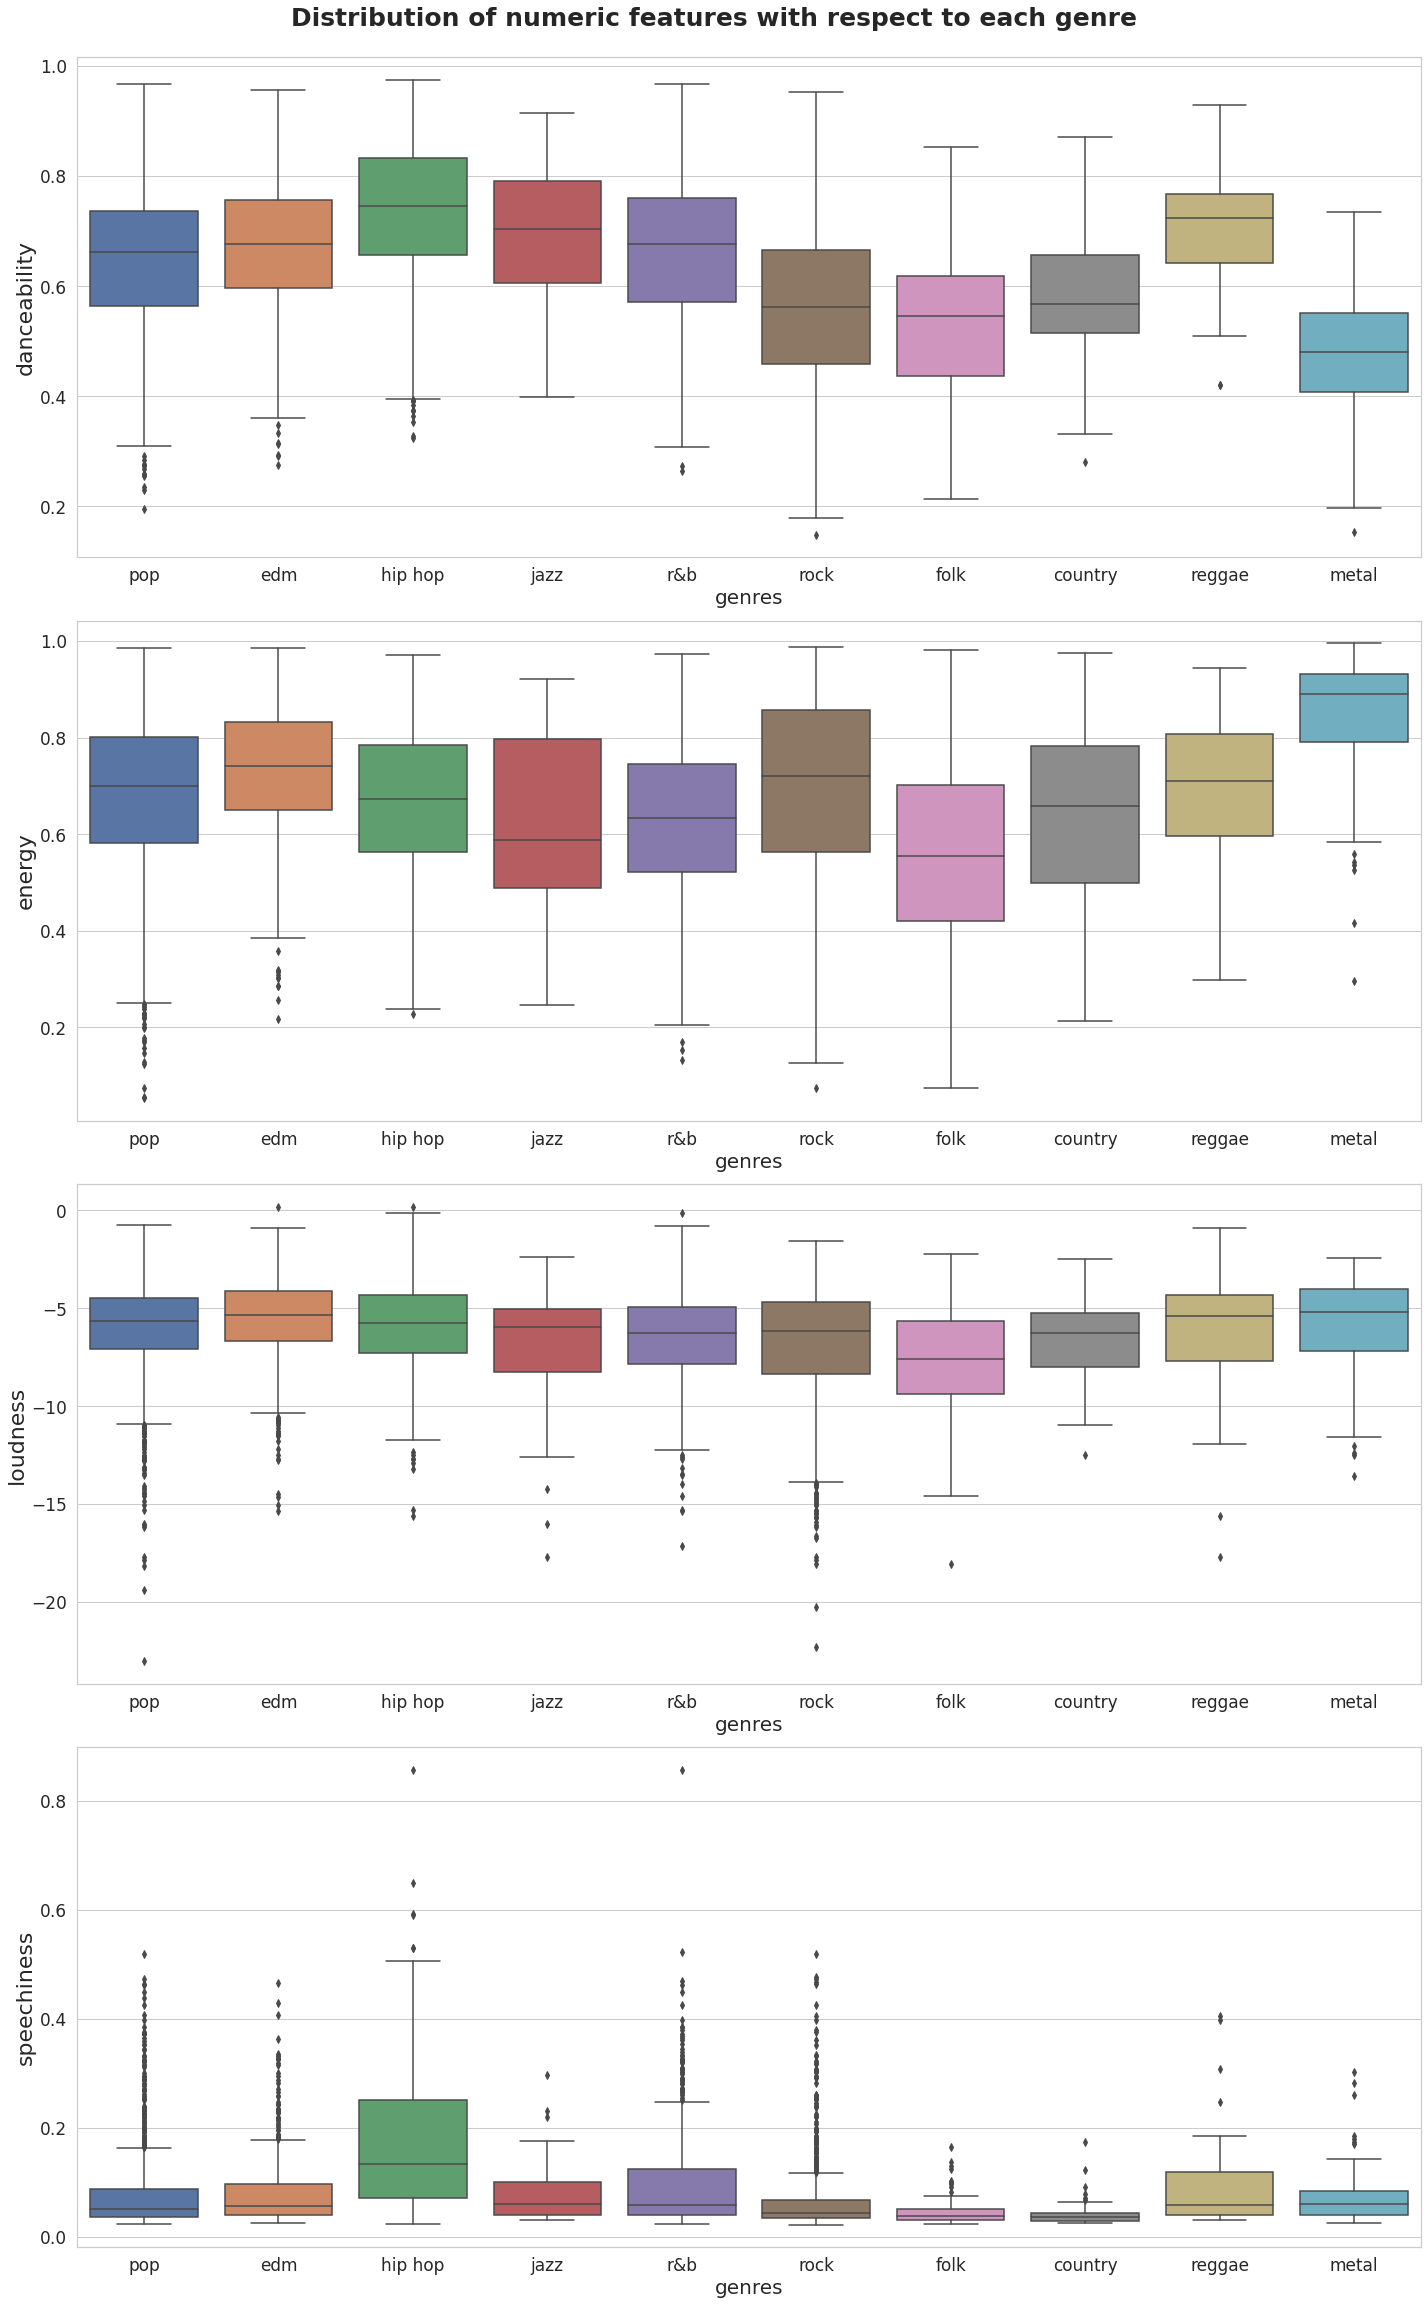

In [370]:
no_instru = num_feature.copy()
no_instru.remove("instrumentalness")
fig, ax = plt.subplots(len(no_instru) // 2, 1, figsize=(20, 8 * (len(no_instru) // 2)))
for i in range(len(no_instru) // 2):
    sns.boxplot(x="genres", y=no_instru[i], data=df_with_genre,  ax=ax[i])
    ax[i].tick_params(labelsize=17)
    ax[i].set_ylabel(ax[i].get_ylabel(), fontsize=22)
    ax[i].set_ylabel(ax[i].get_ylabel(), fontsize=22)
    ax[i].set_xlabel(ax[i].get_xlabel(), fontsize=20)    
fig.suptitle('Distribution of numeric features with respect to each genre', fontsize=25, fontweight='bold', y=1)
fig.tight_layout()
save_plot("num_var_genre_dist_1", fig)

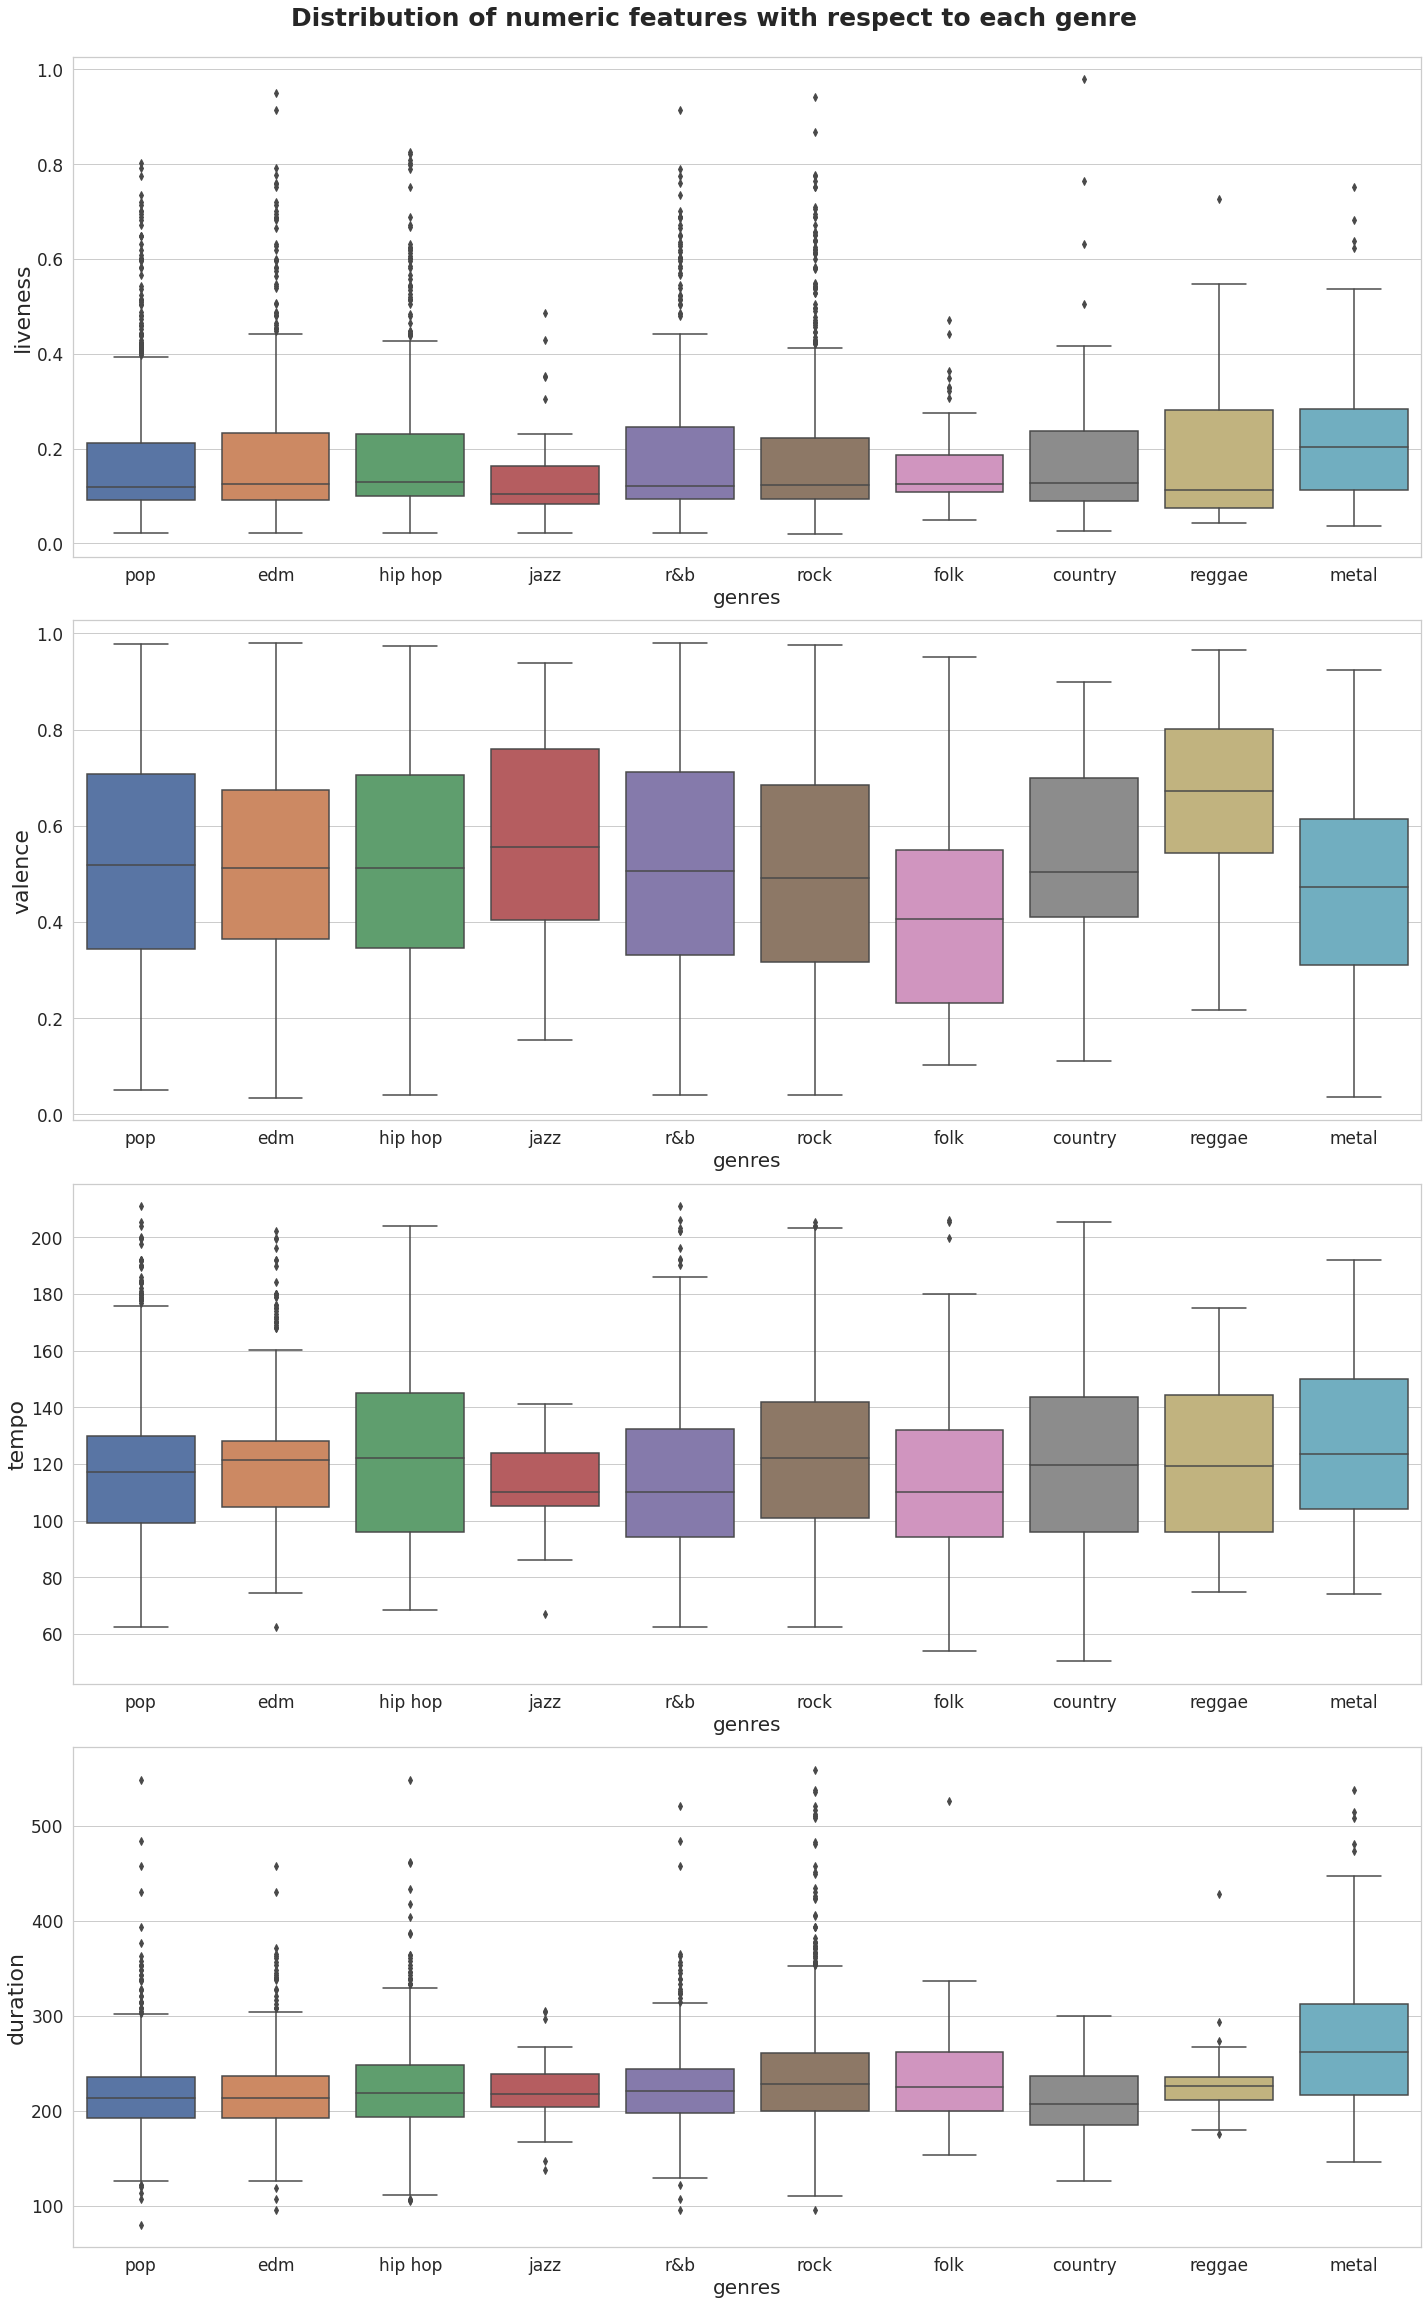

In [371]:
fig, ax = plt.subplots(len(no_instru) // 2, 1, figsize=(20, 8 * (len(no_instru) // 2)))
for i in range(len(no_instru) // 2, len(no_instru)):
    ax_ind = i % 4
    sns.boxplot(x="genres", y=no_instru[i], data=df_with_genre,  ax=ax[ax_ind])
    ax[ax_ind].tick_params(labelsize=17)
    ax[ax_ind].set_ylabel(ax[ax_ind].get_ylabel(), fontsize=22)
    ax[ax_ind].set_ylabel(ax[ax_ind].get_ylabel(), fontsize=22)
    ax[ax_ind].set_xlabel(ax[ax_ind].get_xlabel(), fontsize=20)    
fig.suptitle('Distribution of numeric features with respect to each genre', fontsize=25, fontweight='bold', y=1)
fig.tight_layout()
save_plot("num_var_genre_dist_2", fig)

#### Within each genre which mode is more prominent? todo: change to bar plot

In [181]:
genre_mode = df_with_genre.groupby("genres")["mode"].value_counts()
genre_mode = pd.DataFrame(genre_mode).rename(
    columns={'mode': 'count'}).reset_index()
table = pd.pivot_table(genre_mode, values='count', index='mode',
                       columns=['genres'], aggfunc=np.sum)
table = table.astype(int)


def scale(series):
    return series / series.sum()


for col in table.columns:
    table[col] = scale(table[col])
table.head()


genres   country  electronic-dance      folk   hip hop      jazz     metal  \
mode                                                                         
major   0.833333          0.492154  0.857143  0.551515  0.588235  0.617647   
minor   0.166667          0.507846  0.142857  0.448485  0.411765  0.382353   

genres       pop       r&b    reggae      rock  
mode                                            
major   0.606504  0.576606  0.574468  0.679965  
minor   0.393496  0.423394  0.425532  0.320035

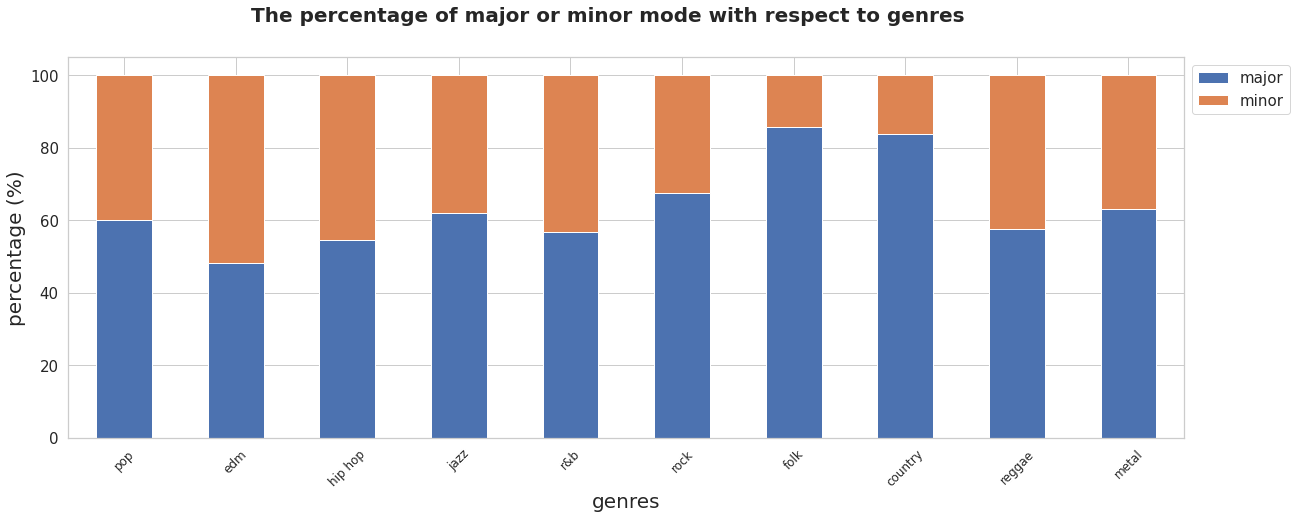

In [377]:
mode_count = df_with_genre.value_counts(["genres", "mode"])
#print(mode_count)
# print(mode_count['folk']['minor'])
mode_table = pd.DataFrame({'genres': (df_with_genre.dropna())['genres'].unique(), 'major': [0.00 for i in range(10)], 
                      'minor': [0.00 for i in range(10)] })

for index, row in mode_table.iterrows():
    genre = row['genres']
    major_count =  mode_count[genre]['major']
    minor_count = mode_count[genre]['minor']
    count = major_count + minor_count

    mode_table.at[index,'major'] = ( major_count / count) * 100
    mode_table.at[index,'minor'] = (minor_count / count) * 100
mode_table.set_index('genres').plot(kind='bar', stacked=True, figsize = (20,7), fontsize = 15)
plt.legend(bbox_to_anchor=(1,1), fontsize = 15)
plt.gcf().suptitle("The percentage of major or minor mode with respect to genres",fontsize=20, fontweight="bold")
plt.xlabel('genres',size = 20)
plt.ylabel('percentage (%)',size = 20)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='center', fontsize=12)
plt.show()


#### Mean views and playcounts of the explicit and non-explicit songs of each genre

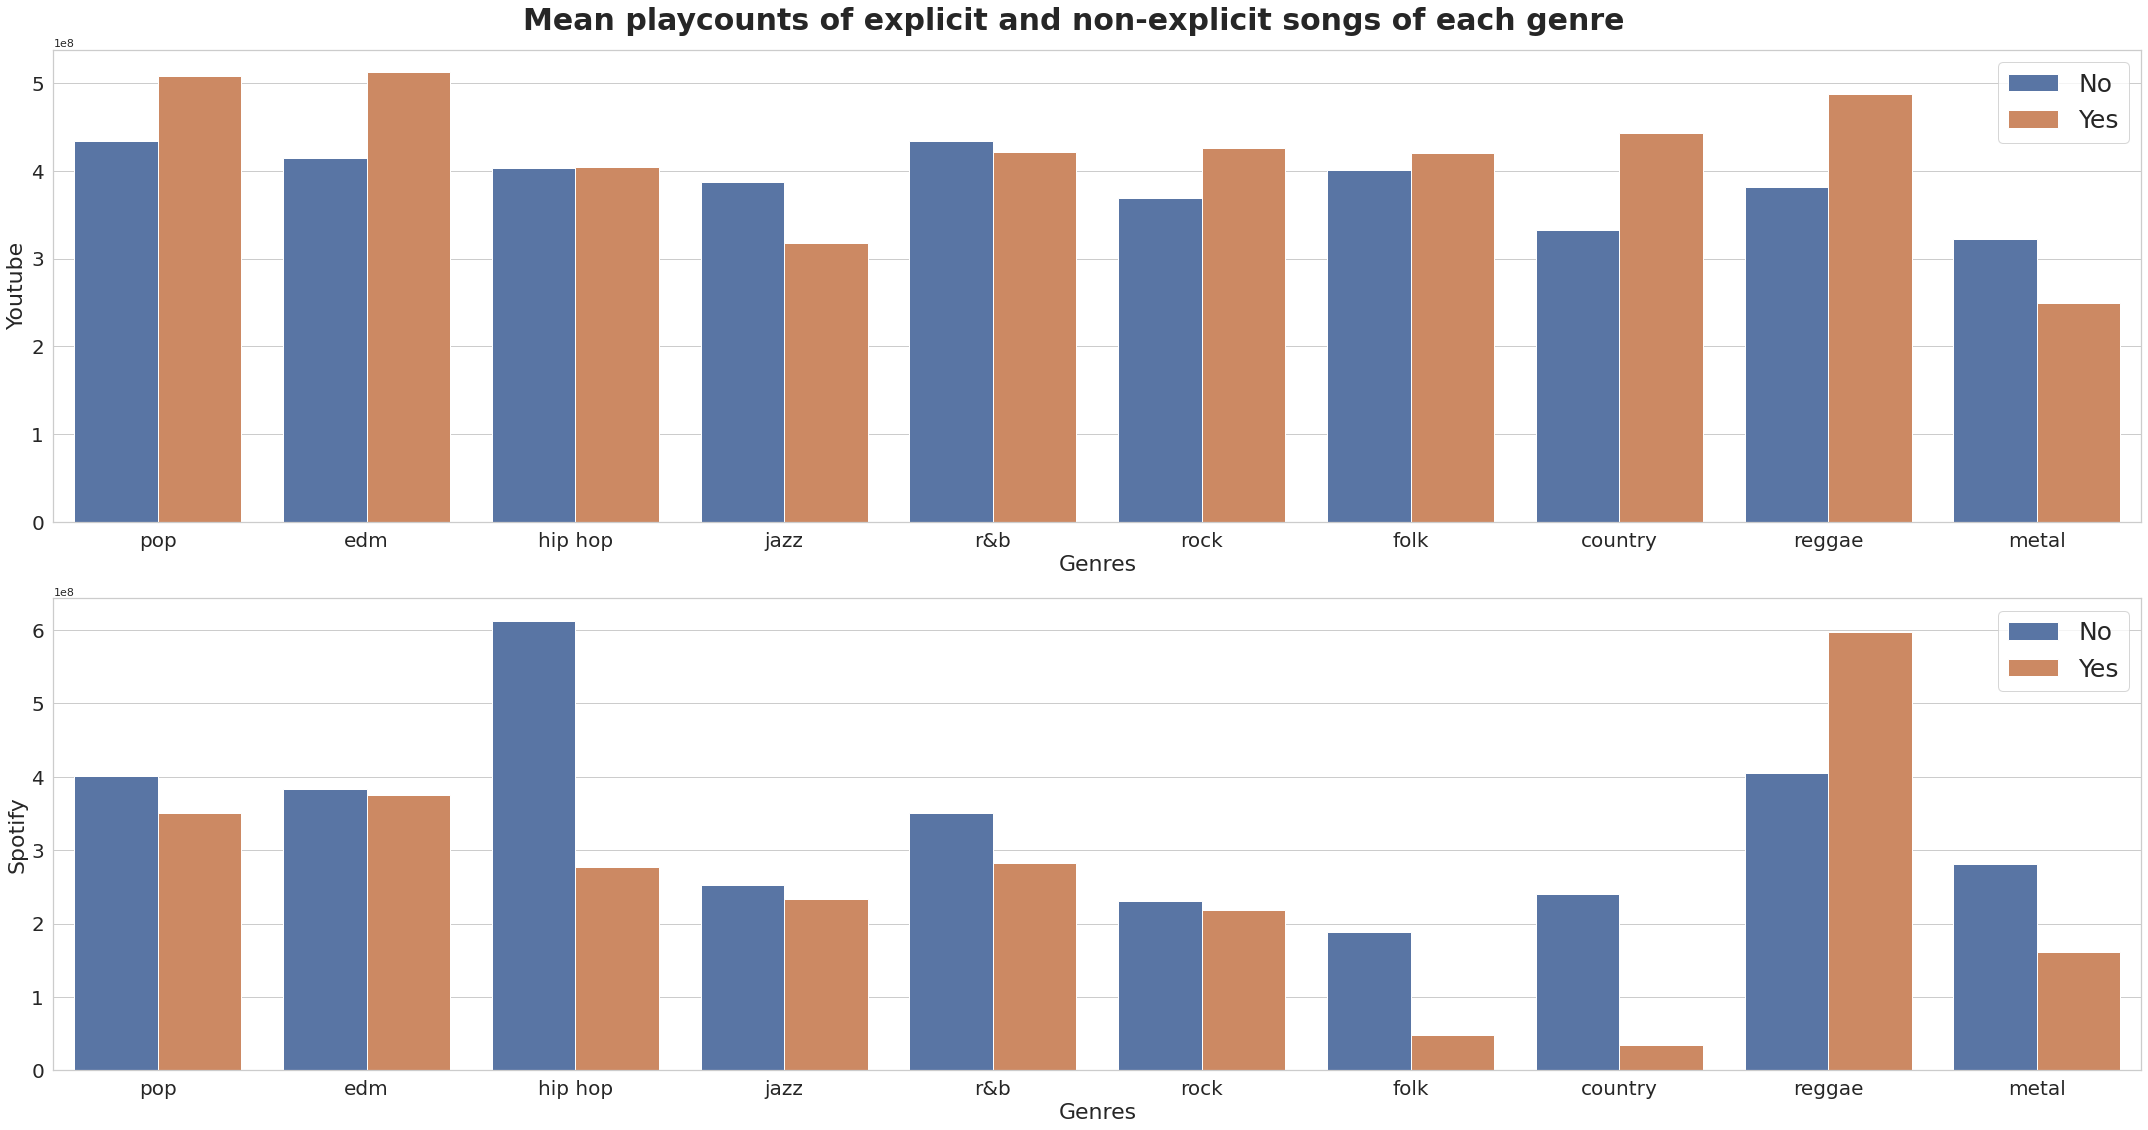

In [391]:
fig, ax = plt.subplots(2, 1, figsize=(30, 16))
sns.barplot(x="genres", y="playcount", data=df_with_genre,
            ax=ax[0], ci=None, hue="explicit")
ax[0].set_ylabel("Youtube")
sns.barplot(x="genres", y="view", data=df_with_genre,
            ax=ax[1], ci=None, hue="explicit")
ax[1].set_ylabel("Spotify")
fig.suptitle("Mean playcounts of explicit and non-explicit songs of each genre", fontsize=30, fontweight='bold')
for a in ax:
    a.tick_params(labelsize=20)
    a.set_ylabel(a.get_ylabel(), fontsize=22)
    a.set_xlabel("Genres", fontsize=22)
    a.legend(prop={'size': 25})
fig.tight_layout()
save_plot("play_explicit_count")

#### Explicit ratio within each genre

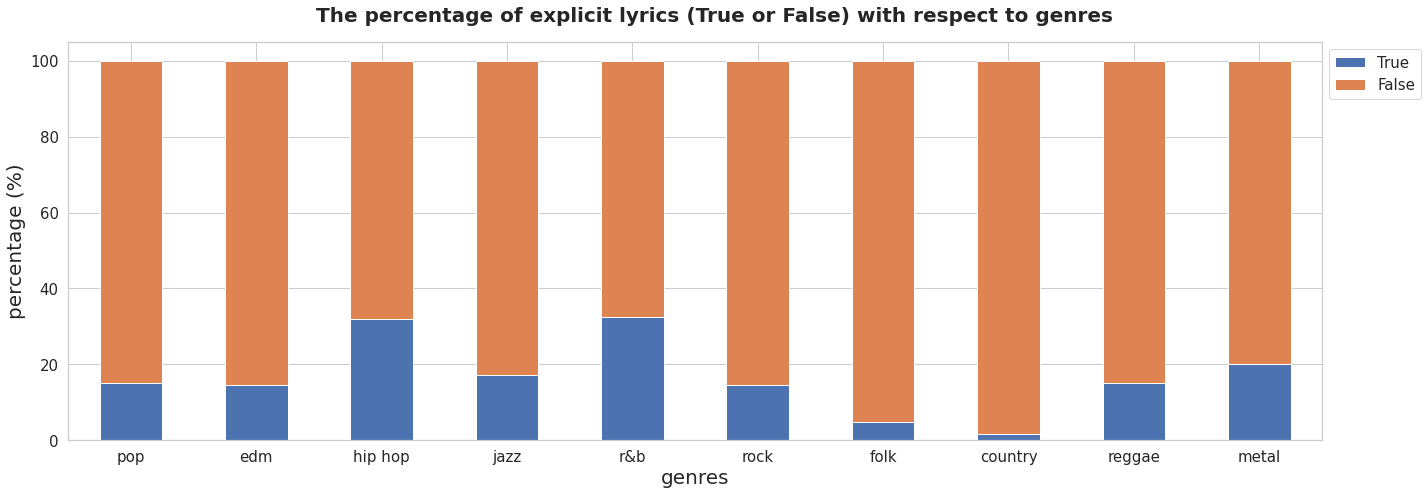

In [395]:
explicit_count = df_with_genre.value_counts(["genres", "explicit"])
explicit_table = pd.DataFrame({'genres': (df_with_genre.dropna())['genres'].unique(), 'True': [0.00 for i in range(10)], 
                      'False': [0.00 for i in range(10)] })

for index, row in mode_table.iterrows():
    genre = row['genres']
    true_count =  explicit_count[genre][1]
    false_count = explicit_count[genre][0]
    count = true_count + false_count

    explicit_table.at[index,'False'] = (false_count / count) * 100
    explicit_table.at[index,'True'] = ( true_count / count) * 100

explicit_table.set_index('genres').plot(kind='bar', stacked=True, figsize = (20,7), fontsize = 15)
plt.legend(bbox_to_anchor=(1,1), fontsize = 15)
plt.gcf().suptitle("The percentage of explicit lyrics (True or False) with respect to genres",fontsize=20, fontweight="bold")
plt.xlabel('genres',size = 20)
plt.ylabel('percentage (%)',size = 20)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=15)
plt.tight_layout()
save_plot("explicit_ratio_genre")

#### Which combinations of genres appear frequently?

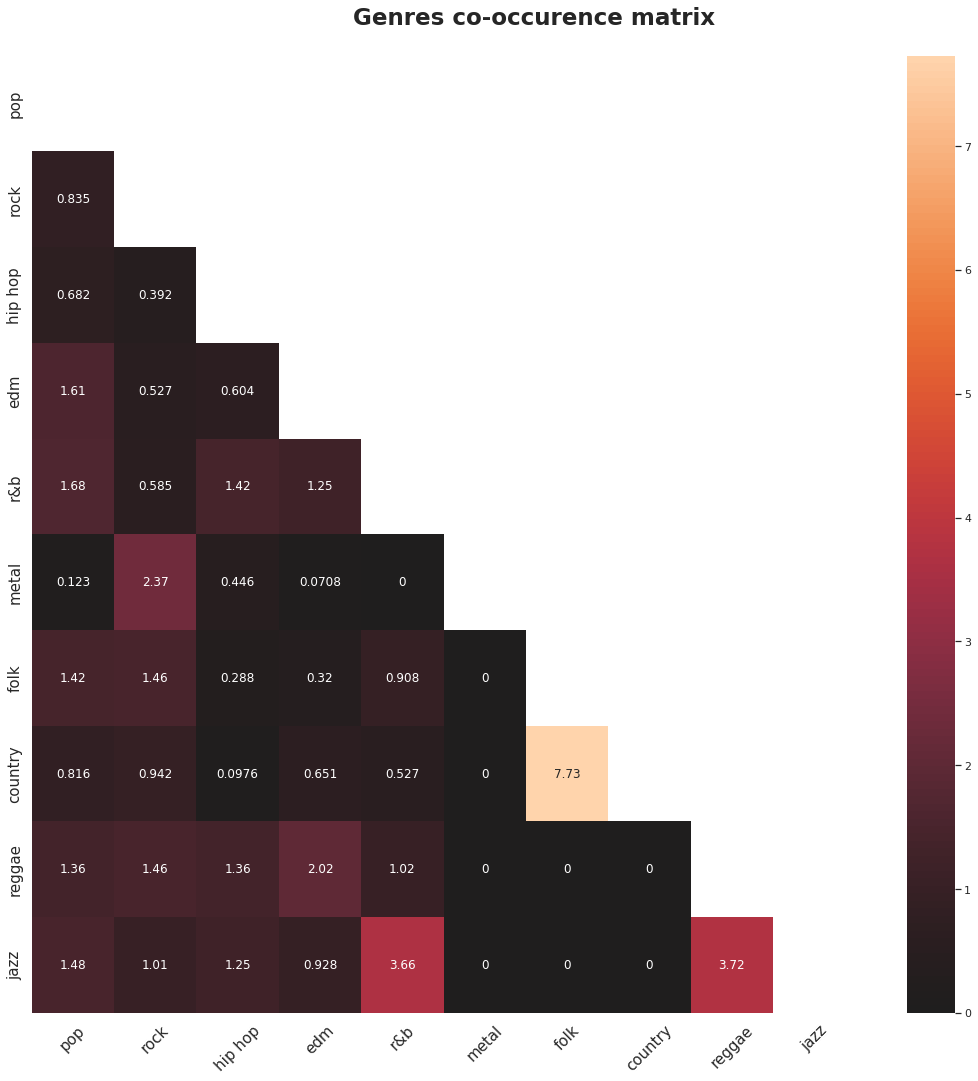

In [402]:
m = ConfusionMatrix(list(df_with_genre["genres"].value_counts().index))
count = df_with_genre["genres"].value_counts()
for genre in count.index:
    m.update_diag(genre, count[genre])

for i, row in df_with_genre.dropna().iterrows():
    if i == 0:
        prev_track = row["track_id"]
        curr_list = [row["genres"]]
        continue
    curr_track = row["track_id"]
    if prev_track != curr_track:
        for pair in findsubsets(curr_list, 2):
            m.increment(pair)
        prev_track = curr_track
        curr_list = [row["genres"]]
    else:
        curr_list.append(row["genres"])
m.normalize()
m.reset_diag()

mask = np.zeros_like(m.matrix)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(m.matrix, annot=True, center=0, fmt=".3g", mask=mask,
            xticklabels=m.ele, yticklabels=m.ele, ax=ax)
fig.suptitle("Genres co-occurence matrix", fontsize=23, fontweight="bold", y=1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='center')
ax.tick_params(labelsize=15)
fig.tight_layout()
save_plot("genre_cooc")

### Release date analysis
The original data is divided into 7 time periods:
- Before 1980: 225 songs
- 1980s: 177 songs
- 1990s: 222 songs
- 2000s: 521 songs
- From 2010 to 2014: 780 songs
- From 2015 to 2017: 1169 songs
- From 2018 to present: 1366 songs

##### Number of songs released in each 5-year interval

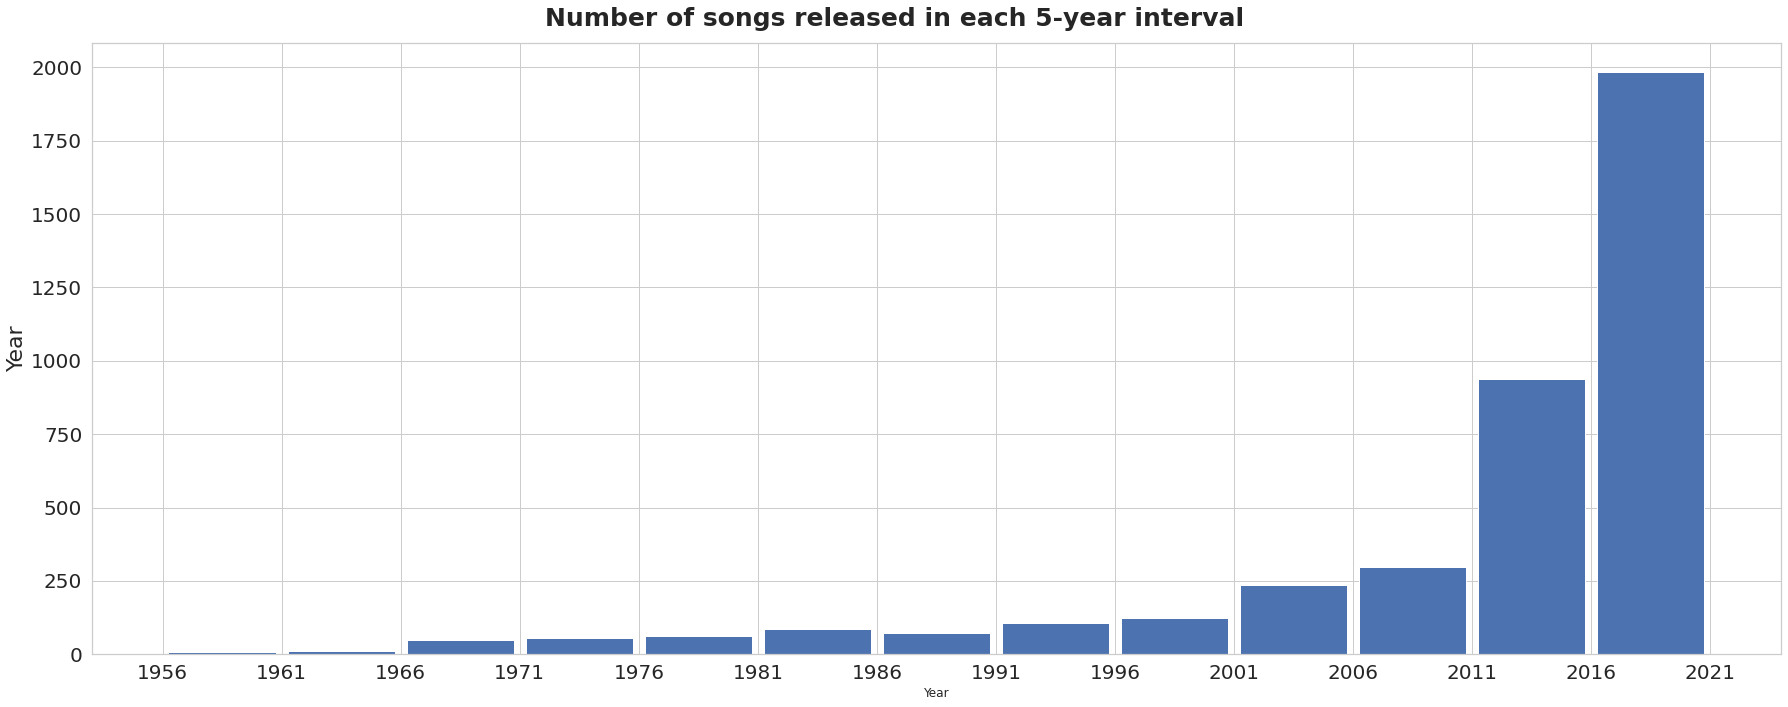

In [417]:
fig, ax = plt.subplots(figsize=(25, 10))
data = df["sp_release_date"]
data = [t.year for t in data]
number = np.arange(min(data), max(data) + 5, 5)
label = map(lambda x: str(x), number)
plt.hist(data, bins=number, rwidth=0.9)
plt.xticks(number, label)
plt.xlabel("Year")
plt.ylabel("Count")
plt.suptitle("Number of songs released in each 5-year interval", fontsize=25, fontweight='bold')
ax.tick_params(labelsize=20)
ax.set_ylabel("Count", fontsize=22)
ax.set_ylabel("Year", fontsize=22)
fig.tight_layout()
save_plot("year_count")

#### Average view and playcount by year (dropped)

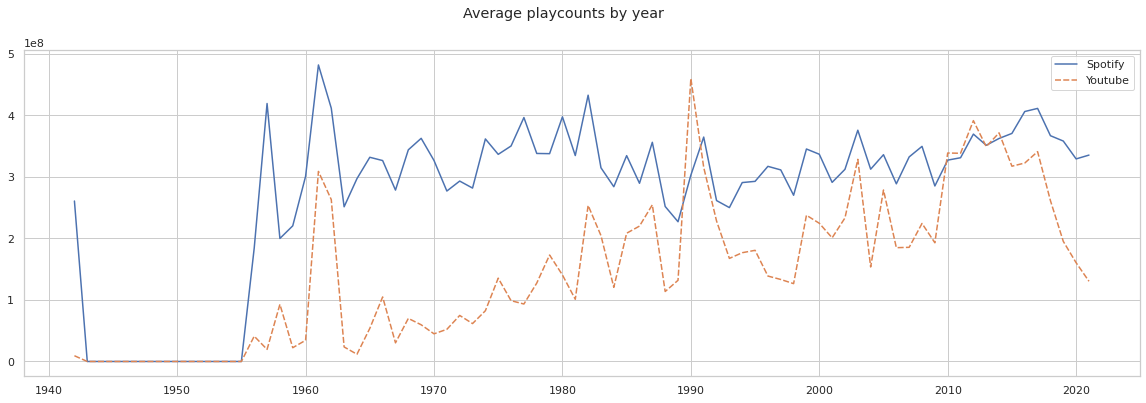

In [116]:
plt.figure(figsize=(20, 6))
plot_popularity_by_year(df)
plt.suptitle("Average playcounts by year")
save_plot("play_year")

#### Average view and playcount by time hand-splitted time period

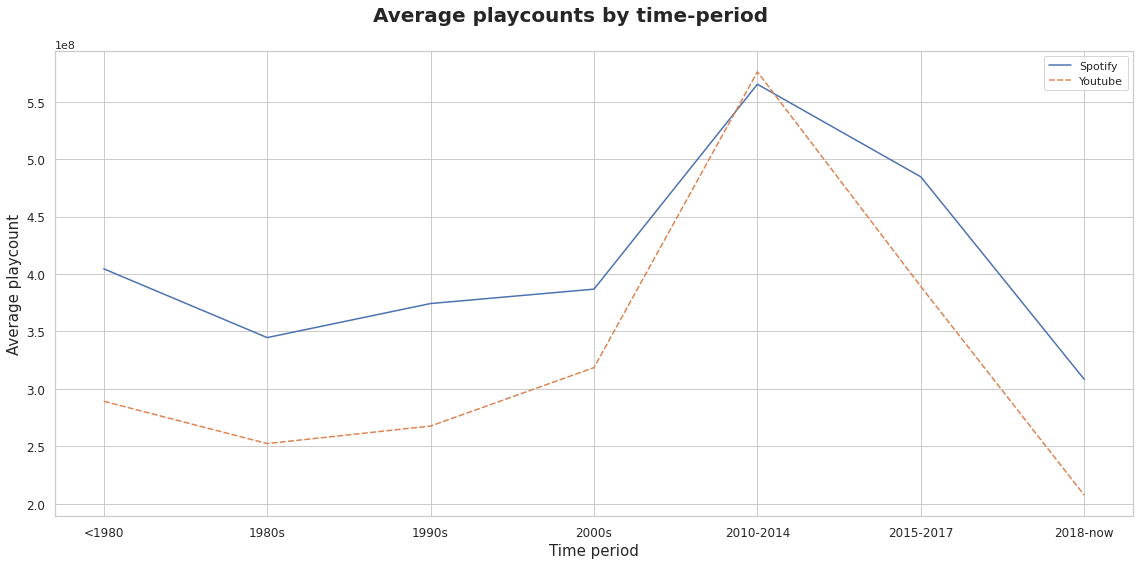

In [423]:
fig, ax = plt.subplots(figsize=(16,8))
plot_popularity_by_eras(df_with_genre, ax=ax)
fig.suptitle("Average playcounts by time-period", fontsize=20, fontweight="bold")
ax.tick_params(labelsize=12)
ax.set_xlabel("Time period", fontsize=15)
ax.set_ylabel("Average playcount", fontsize=15)
fig.tight_layout()
save_plot("play_era")

<AxesSubplot:xlabel='year', ylabel='playcount'>

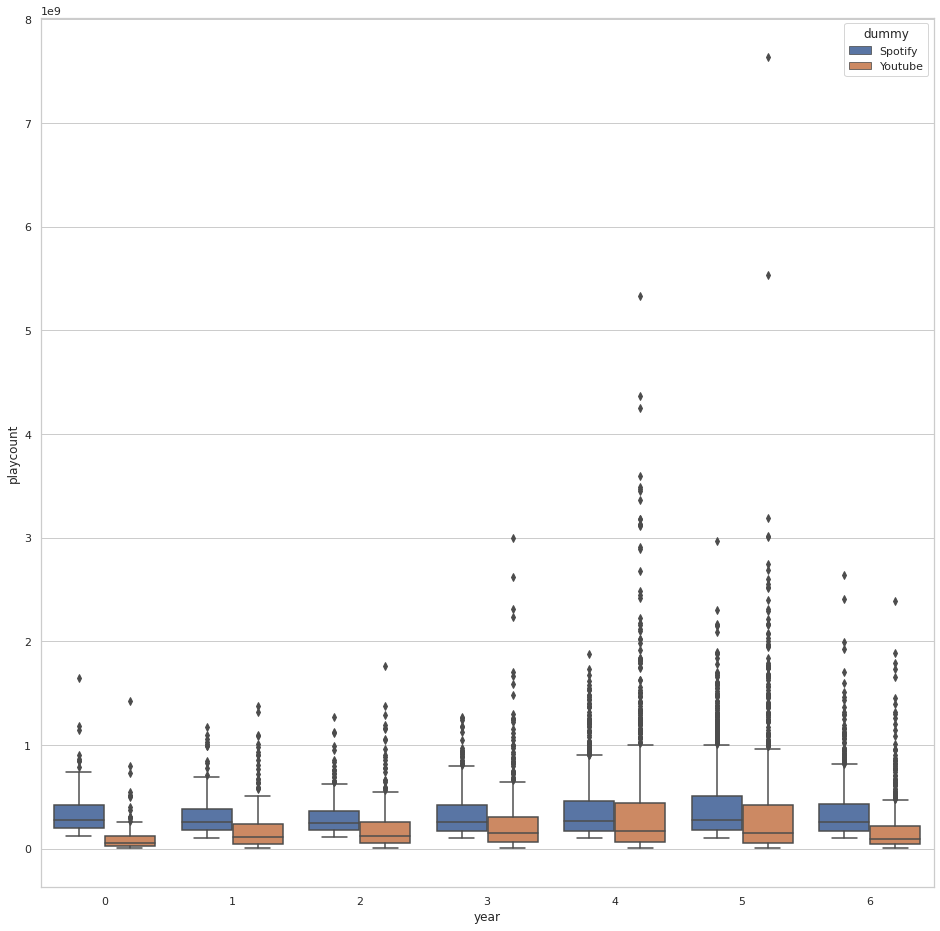

In [414]:
plt.figure(figsize=(16,16))
df_year = df.copy()
# df_year["playcount"] = df_year["playcount"].apply(log10)
# df_year["view"] = df_year["view"].apply(log10)
df_year['year'] = df['sp_release_date'].dt.year
eras_df = discretize(data=df_year, col='year', value_range=eras, inf='both')
box_df1 = eras_df[["playcount", "year"]].copy()
box_df1["dummy"] = ["Spotify" for i in range(len(eras_df))]
box_df2 = eras_df[["view", "year"]].copy()
box_df2.rename(columns = {"view":"playcount"}, inplace=True)
box_df2["dummy"] = ["Youtube" for i in range(len(eras_df))]
box_df = box_df1.append(box_df2, ignore_index=True)
sns.boxplot(data=box_df, x='year', y='playcount', hue='dummy')

#### Now for each genre

##### By year (dropped)

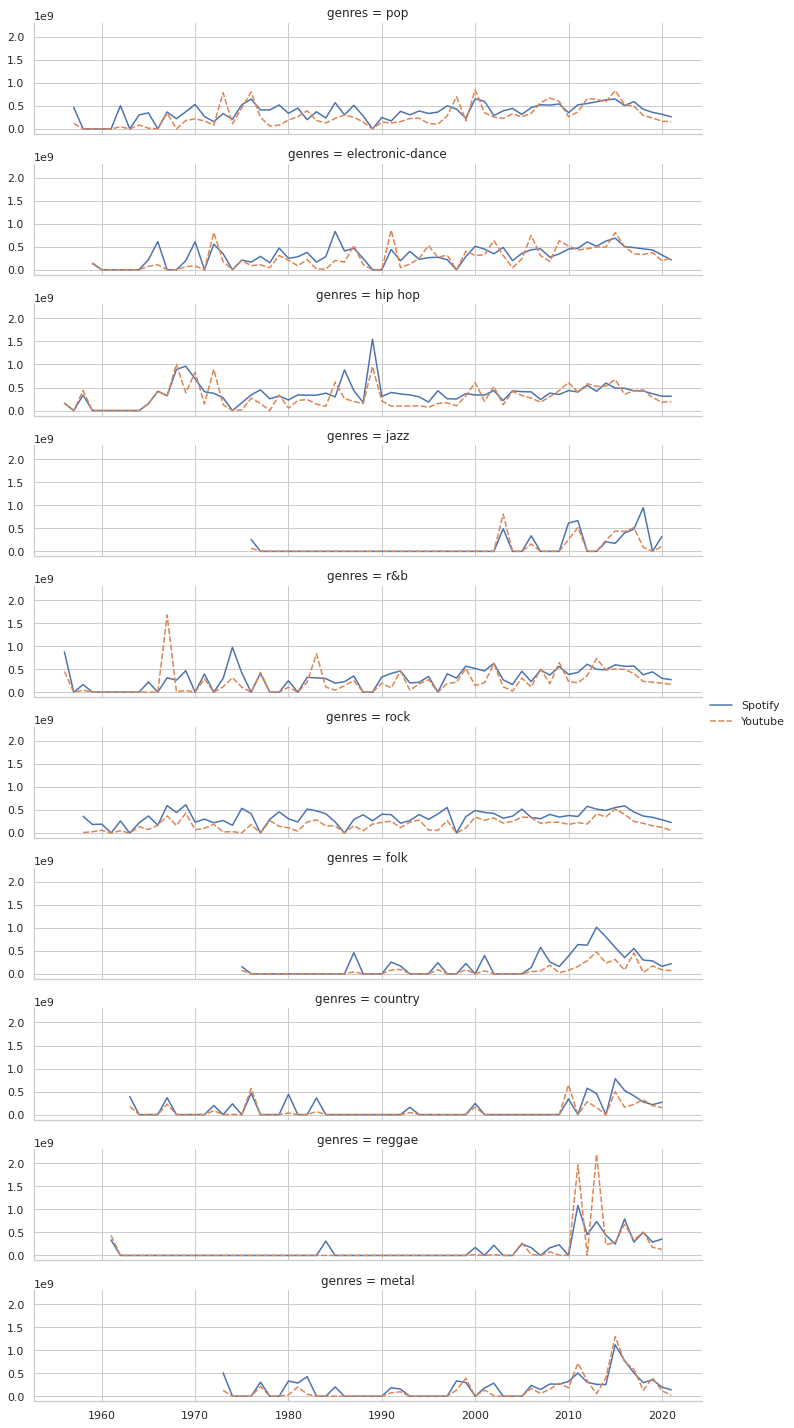

In [118]:
g = sns.FacetGrid(df_with_genre, row="genres", aspect=5, height=2)
g.map_dataframe(plot_popularity_by_year)
g.add_legend()
save_plot("play_year_genre")

##### By time period (dropped)

In [450]:
df_year_with_genre = df_with_genre.copy()
df_year_with_genre['year'] = df_year_with_genre['sp_release_date'].dt.year
eras_df = discretize(data=df_year_with_genre, col='year', value_range=eras, inf='both')
eras_df.head()
eras_df[eras_df["genres"] == "jazz"]['year'].unique()

[5, 4, 3, 1, 0, 2, 6]
Categories (7, int64): [0 < 1 < 2 < 3 < 4 < 5 < 6]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


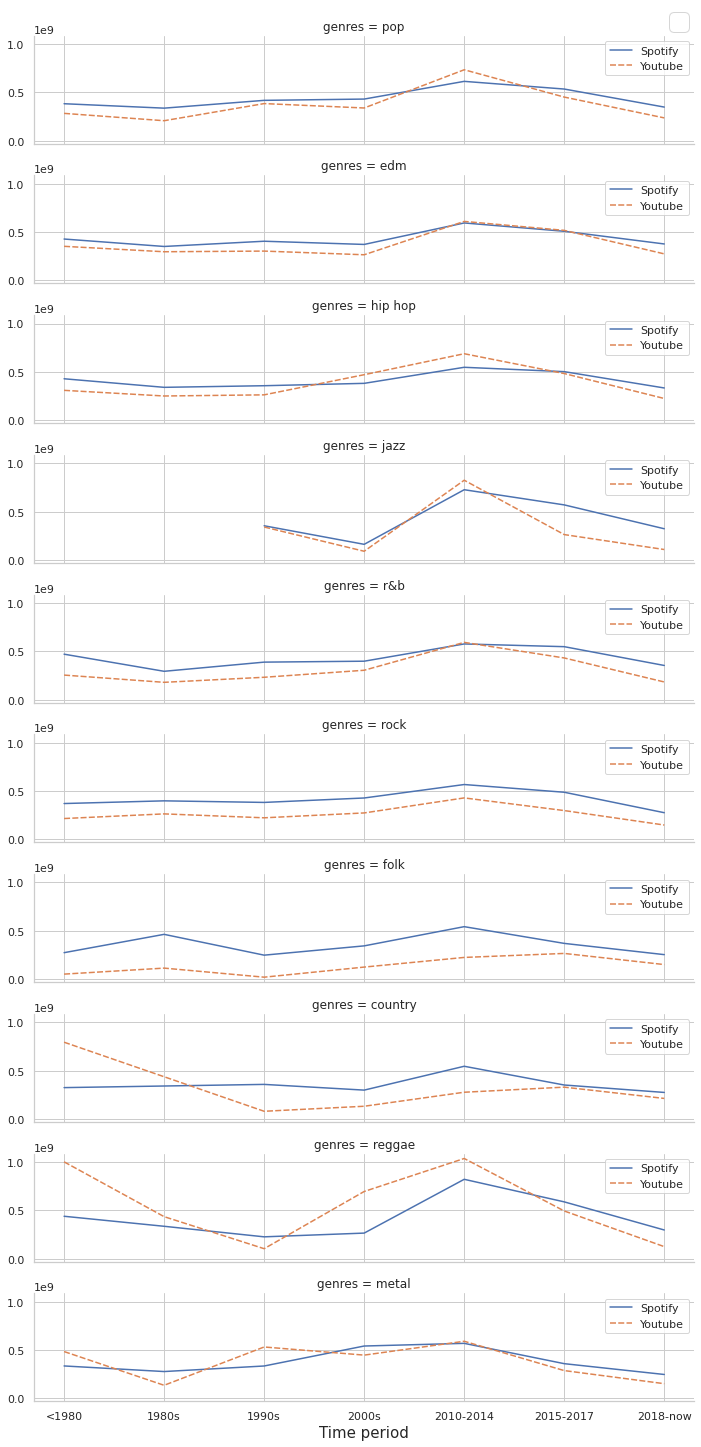

In [448]:
g = sns.FacetGrid(df_with_genre, row="genres", aspect=5, height=2)
fig = g.figure
fig.suptitle("", fontsize=15, fontweight='bold')
fig.legend(prop={'size': 25}, loc ='upper right')
g.map_dataframe(plot_popularity_by_eras)
for ax in g.axes.ravel():
    ax.legend()
g.set_xlabels("Time period", fontsize=15)
save_plot("play_era_genre")

#### Most popular genres in each time period

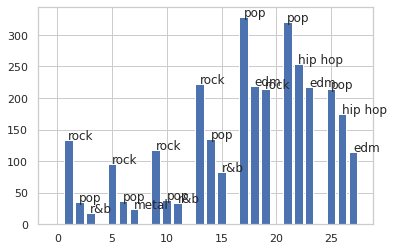

In [472]:
df_year_with_genre = df_with_genre.copy()
df_year_with_genre['year'] = df_year_with_genre['sp_release_date'].dt.year
eras_df = discretize(data=df_year_with_genre, col='year', value_range=eras, inf='both')
count = eras_df.groupby(["year", "genres"])["playcount"].count().reset_index()
count = count.set_index("genres").groupby("year")['playcount'].nlargest(3).reset_index()
val = []
label = []

fig, ax = plt.subplots()
for i in range(len(count)):
    if i % 3 == 0:
        val.append(0)
        label.append("")
    val.append(count["playcount"][i])
    label.append(count["genres"][i])

ax.bar(range(len(val)), val)
for i in range(len(val)):
    ax.text(i, val[i] + 1, label[i])

### Very popular songs analysis (dropped)

#### Discretize playcount and view into 2 groups, 0-500mil and >500mil

In [404]:
df_dis = discretize(df_with_genre, 'playcount', popularity, cat_name=["The rest", "Top"])
df_dis = discretize(df_dis, 'view', popularity, cat_name=["The rest", "Top"])
df_dis["Both Platform"] =  (df_dis["playcount"] == "Top") & (df_dis['view'] == "Top")
def suffer(x):
    if x:
        return "Top"
    else:
        return "The rest"
df_dis["Both Platform"] = df_dis["Both Platform"].apply(suffer)

#### Distribution of numeric features for Top and The rest

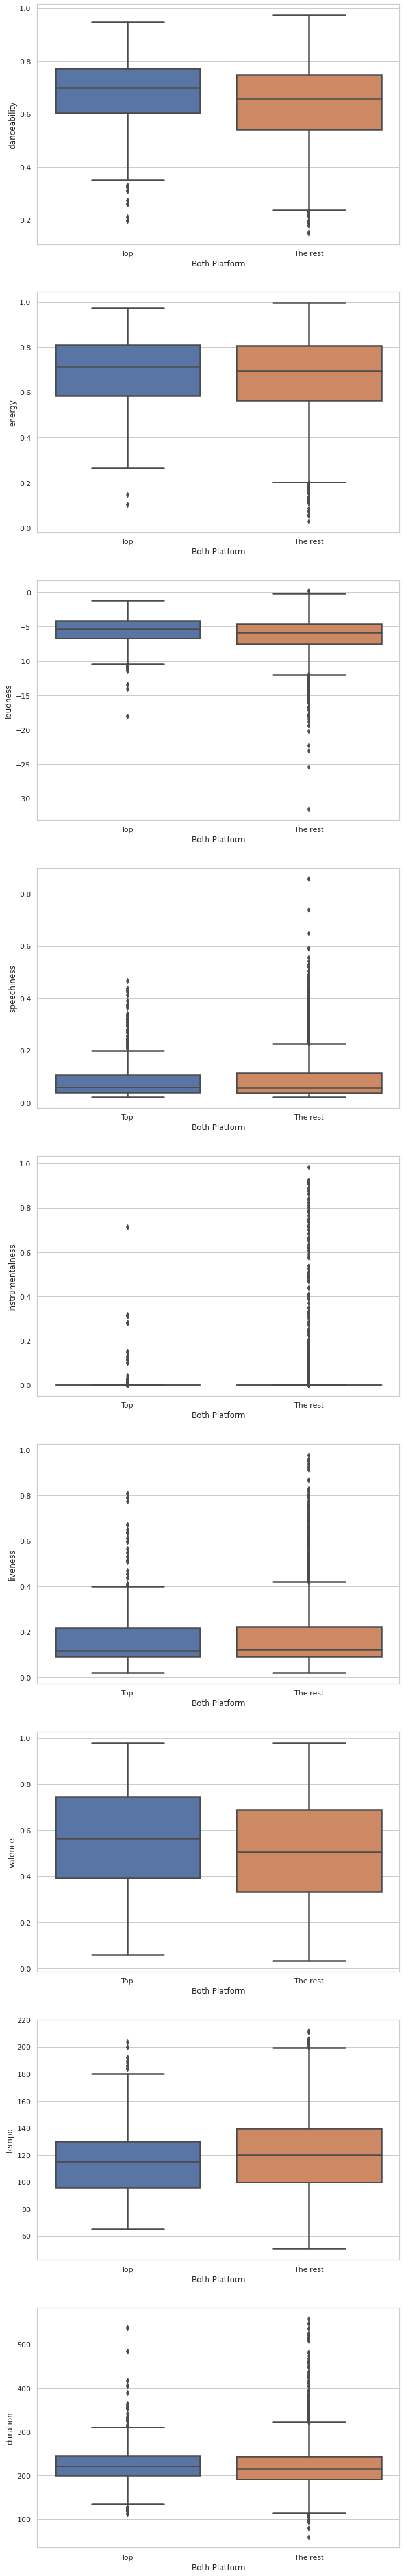

In [405]:
fig, axes = plt.subplots(len(num_feature), 1, figsize=(10, 8 * len(num_feature)))
for i in range(len(num_feature)):
    sns.boxplot(x="Both Platform", y=num_feature[i],
                    data=df_dis, linewidth=2.5, ax=axes[i])
    # axes[i].tick_params('x', labelrotation=30)

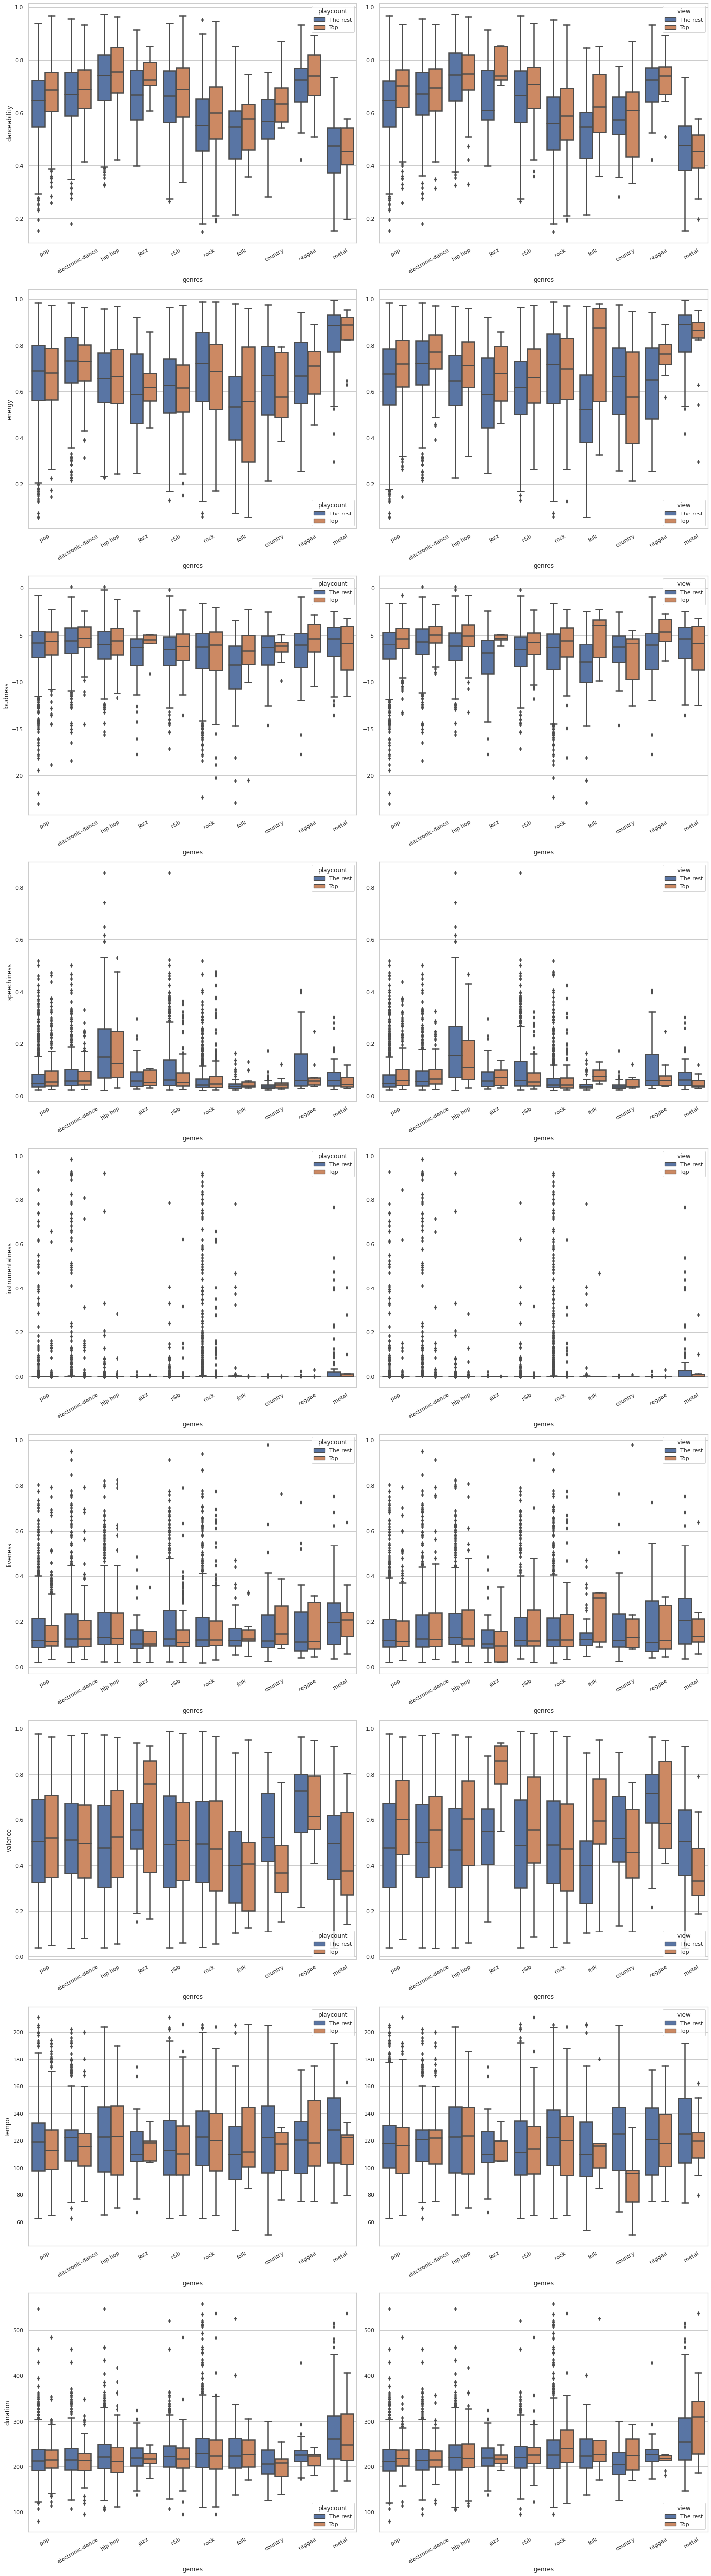

In [129]:
fig, axes = plt.subplots(len(num_feature), 2, figsize=(20, 8 * len(num_feature)))
for i in range(len(num_feature)):
    sns.boxplot(x="genres", y=num_feature[i], hue="playcount",
                    data=df_dis, linewidth=2.5, ax=axes[i, 0])
    sns.boxplot(x="genres", y=num_feature[i], hue="view",
                    data=df_dis, linewidth=2.5, ax=axes[i, 1])
    axes[i, 1].set_ylabel("")
    axes[i, 1].tick_params('x', labelrotation=30)
    axes[i, 0].tick_params('x', labelrotation=30)
save_plot("very_num_var_dist_sep", fig)
fig.tight_layout()

In [ ]:
for i in range(len(num_feature)):
    sns.boxplot(x="genres", y=num_feature[i], hue="playcount",
                    data=df_dis, linewidth=2.5, ax=axes[i])
    axes[i].tick_params('x', labelrotation=30)
save_plot("very_num_var_dist", fig)
fig.tight_layout()

#### Genre count

<AxesSubplot:xlabel='index', ylabel='genres'>

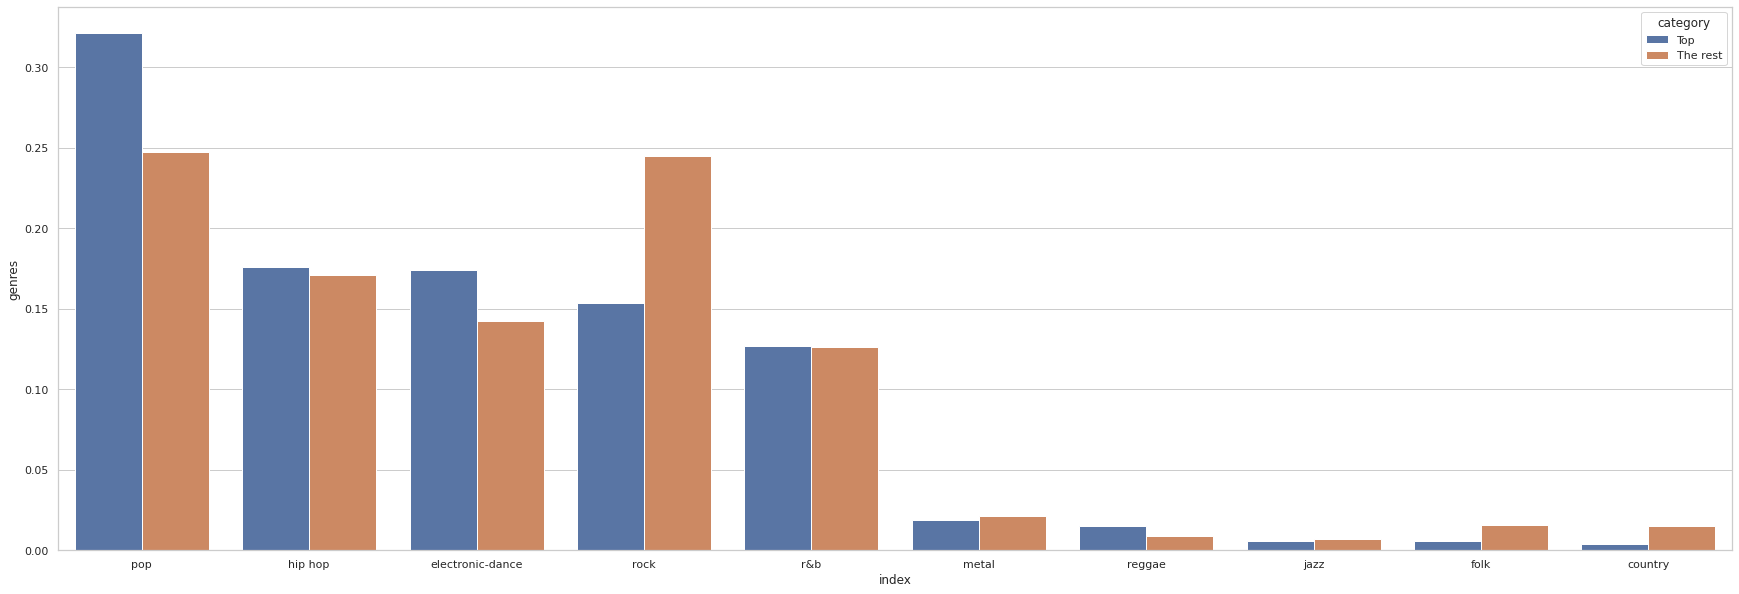

In [198]:
fig, ax = plt.subplots(figsize=(30, 10))
# fig, ax = plt.subplots(figsize=(16,8))
top = df_dis[df_dis["Both Platform"] == "Top"]
bot = df_dis[df_dis["Both Platform"] == "The rest"]
top = top["genres"].value_counts() / top["genres"].value_counts().sum()
bot = bot["genres"].value_counts() / bot["genres"].value_counts().sum()

top = top.reset_index()
top["category"] = ["Top" for i in range(10)]

bot = bot.reset_index()
bot["category"] = ["The rest" for i in range(10)]

combined = top.append(bot, ignore_index=True)
sns.barplot(x="index", y="genres", data=combined, hue="category", ax=ax)

# sns.countplot(x="genres", data=top,
#               order=top['genres'].value_counts(dropna=True).index, ax=ax)
# for p in ax.patches:
#     ax.annotate(str(p.get_height()), (p.get_x() *
#                 1.005 + 0.35, p.get_height() + 1))
# fig.suptitle("Number of songs in each genres", fontsize=20)

### Hypothesis testing

#### Does the mode of a song affect its popularity?

In [21]:
minor = df[df["mode"] == "minor"]
major = df[df["mode"] == "major"]
def log10(x):
    return log(x, 10)
df_log = df.copy()
df_log["playcount"] = df_log["playcount"].apply(log10)
df_log["view"] = df_log["view"].apply(log10)

In [22]:
p_playcount = ztest(minor["playcount"], major["playcount"])[1]
p_view = ztest(minor["view"], major["view"])[1]
print(f"playcount p value: {p_playcount}")
print(f"view p value: {p_view}")

playcount p value: 0.4424637210762481
view p value: 0.004744498658183037


In [23]:
compare_mean = CompareMeans.from_data(minor["view"], major["view"])
compare_mean.ztest_ind()

(2.8238878271234773, 0.004744498658183043)

<AxesSubplot:xlabel='mode', ylabel='view'>

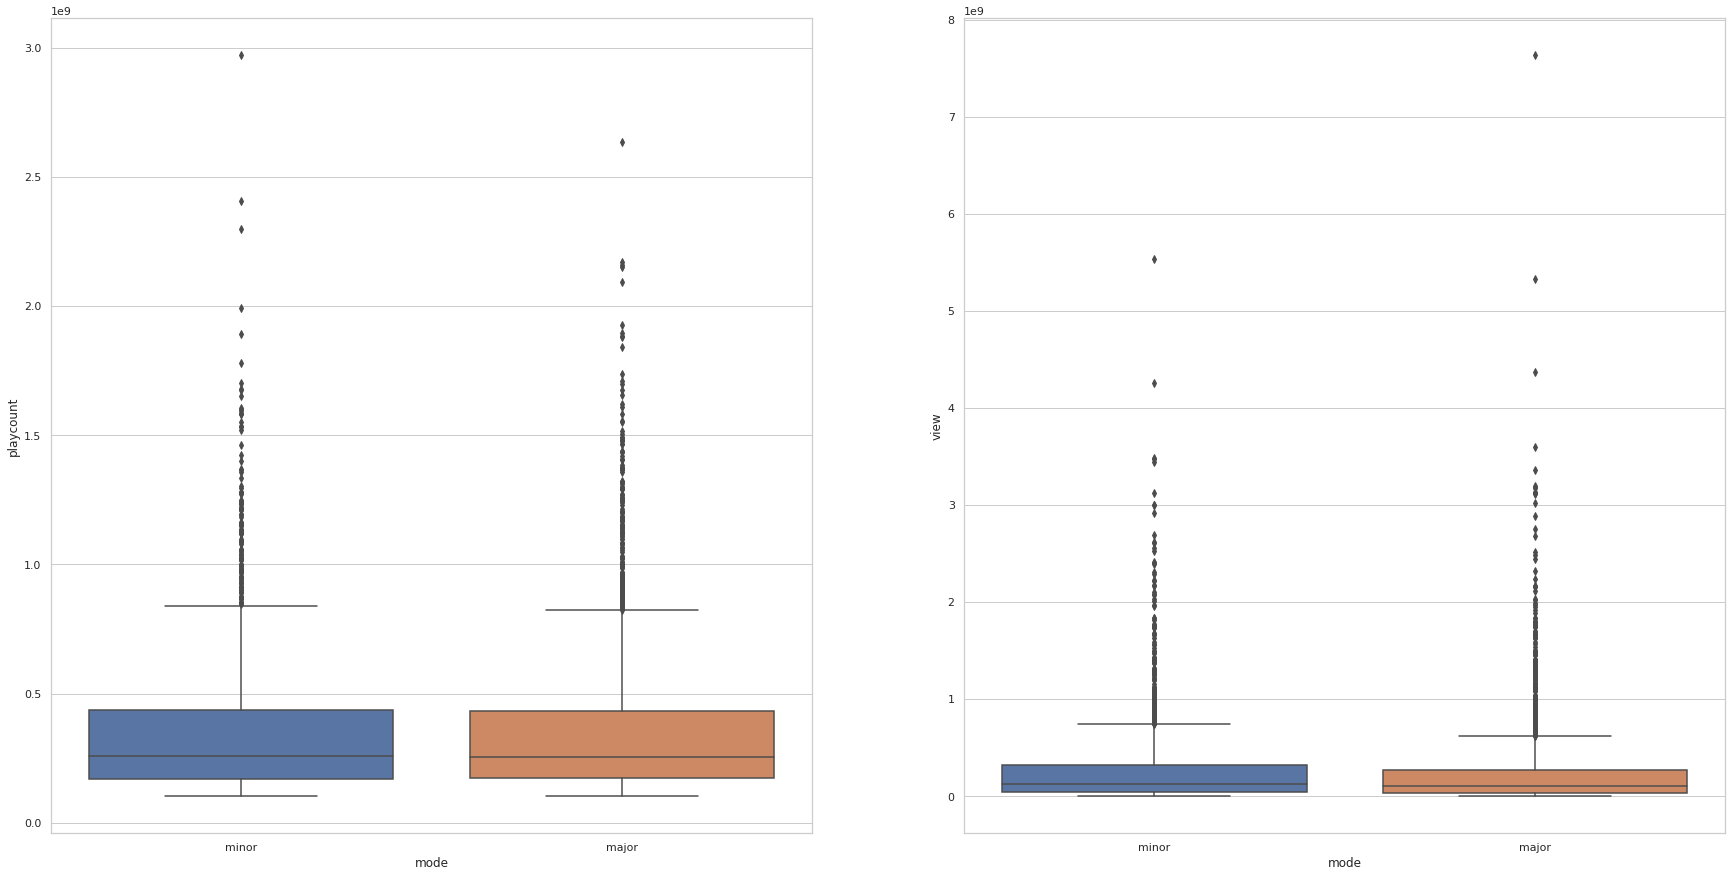

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(30, 15))
sns.boxplot(x="mode", y="playcount", data=df, ax=ax[0])
sns.boxplot(x="mode", y="view", data=df, ax=ax[1])

### Parallel plot (dropped)

In [81]:
df_playcount_split, interval = discretize(df_raw, 'playcount', popularity, return_interval=True)
print(interval)
df_playcount_split['playcount'].unique()

IntervalIndex([(0.0, 500000000.0], (500000000.0, inf]],
              closed='right',
              dtype='interval[float64]')


[1, 0]
Categories (2, int64): [0 < 1]

In [84]:
fig = px.parallel_coordinates(df_playcount_split[['valence', 'danceability', 'energy', 'explicit']], color="explicit")
fig.show()

#### Just some code examples

In [208]:
import plotly.graph_objects as go

import pandas as pd

test = pd.read_csv("https://raw.githubusercontent.com/bcdunbar/datasets/master/parcoords_data.csv")

fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = test['colorVal'],
                   colorscale = 'Electric',
                   showscale = True,
                   cmin = -4000,
                   cmax = -100),
        dimensions = list([
            dict(
               #   constraintrange = [100000,150000],
                 label = "Block Height", values = test['blockHeight']),
            dict(range = [0,700000],
                 label = 'Block Width', values = test['blockWidth']),
            dict(tickvals = [0,0.5,1,2,3],
                 ticktext = ['A','AB','B','Y','Z'],
                 label = 'Cyclinder Material', values = test['cycMaterial']),
            dict(range = [-1,4],
                 tickvals = [0,1,2,3],
                 label = 'Block Material', values = test['blockMaterial']),
            dict(range = [134,3154],
                 visible = True,
                 label = 'Total Weight', values = test['totalWeight']),
            dict(range = [9,19984],
                 label = 'Assembly Penalty Wt', values = test['assemblyPW']),
            dict(range = [49000,568000],
                 label = 'Height st Width', values = test['HstW'])])
    )
)
fig.show()

In [195]:
test = px.data.iris()
fig = px.parallel_coordinates(test, color="species_id", labels={"species_id": "Species",
                "sepal_width": "Sepal Width", "sepal_length": "Sepal Length",
                "petal_width": "Petal Width", "petal_length": "Petal Length", },
                             color_continuous_scale=px.colors.diverging.Tealrose,
                             color_continuous_midpoint=2
                             )
fig.show()

#### Utter garbage

In [82]:
import plotly.graph_objects as go
df_view_plit = discretize(df_with_genre, 'view', popularity)
explicit_val = []
genre_val = []
view_val = []
for _, row in df_view_plit.iterrows():
    explicit_val.append(row['explicit'])
    genre_val.append(row['genres'])
    view_val.append(row['view'])
fig = go.Figure(go.Parcats(
    dimensions=[
        {'label': 'Explicit',
         'values': explicit_val},
        {'label': 'Genres',
         'values': genre_val},
        {'label': 'View',
         'values': view_val}]
))

fig.show()

### Sankey diagram (dropped)

In [100]:
import random
color_test = [f'hsl({c[0]:.0%},{c[1]:.0%},{c[2]:.0%})' for c in sns.color_palette(palette='hls', n_colors=len(data['data'][0]['node']['color']))]
random.shuffle(color_test)

In [110]:
df.values

array([['Shape of You', '0FE9t6xYkqWXU2ahLh6D8X', 'Ed Sheeran', ...,
        'Ed Sheeran', '2017-01-30T10:57:50Z',
        'Ed Sheeran - Shape of You (Official Music Video)'],
       ['Blinding Lights', '0sf12qNH5qcw8qpgymFOqD', 'The Weeknd', ...,
        'TheWeekndVEVO', '2019-11-29T05:00:08Z',
        'The Weeknd - Blinding Lights (Official Audio)'],
       ['Dance Monkey', '5ZULALImTm80tzUbYQYM9d', 'Tones And I', ...,
        'Tones And I', '2019-06-24T22:01:36Z',
        'TONES AND I - DANCE MONKEY (OFFICIAL VIDEO)'],
       ...,
       ["I Love You's", '60todhJq1ScRkVxFvXTuZF', 'Hailee Steinfeld',
        ..., 'HaileeSteinfeldVEVO', '2020-03-31T20:00:09Z',
        'Hailee Steinfeld - I Love You&#39;s (Official Video)'],
       ['Girls Like Us', '5SFXOMJJ334Wn2PwBHeRZN', 'Zoe Wees', ...,
        'ZoeWeesVEVO', '2021-01-14T17:00:11Z',
        'Zoe Wees - Girls Like Us'],
       ['m y . l i f e (with 21 Savage & Morray)',
        '1D3z6HTiQsNmZxjl7F7eoG', 'J. Cole', ..., 'J. Cole',
 

In [ ]:
all_nodes = european_countries_migration.Country.values.tolist() + european_countries_migration.Measure.values.tolist()
source_indices = [all_nodes.index(country) for country in european_countries_migration.Country]
target_indices = [all_nodes.index(measure) for measure in european_countries_migration.Measure]

colors = pex.colors.qualitative.D3

node_colors_mappings = dict([(node,np.random.choice(colors)) for node in all_nodes])
node_colors = [node_colors_mappings[node] for node in all_nodes]
edge_colors = [node_colors_mappings[node] for node in european_countries_migration.Country]

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 20,
      thickness = 20,
      line = dict(color = "black", width = 1.0),
      label =  all_nodes,
      color =  node_colors,
    ),

    link = dict(
      source =  source_indices,
      target =  target_indices,
      value =  european_countries_migration.Value,
      color = edge_colors,
))])

fig.update_layout(title_text="Population Migration between New Zealand and European Countries",
                  height=600,
                  font_size=10)
fig.show()

### Miscellaneous

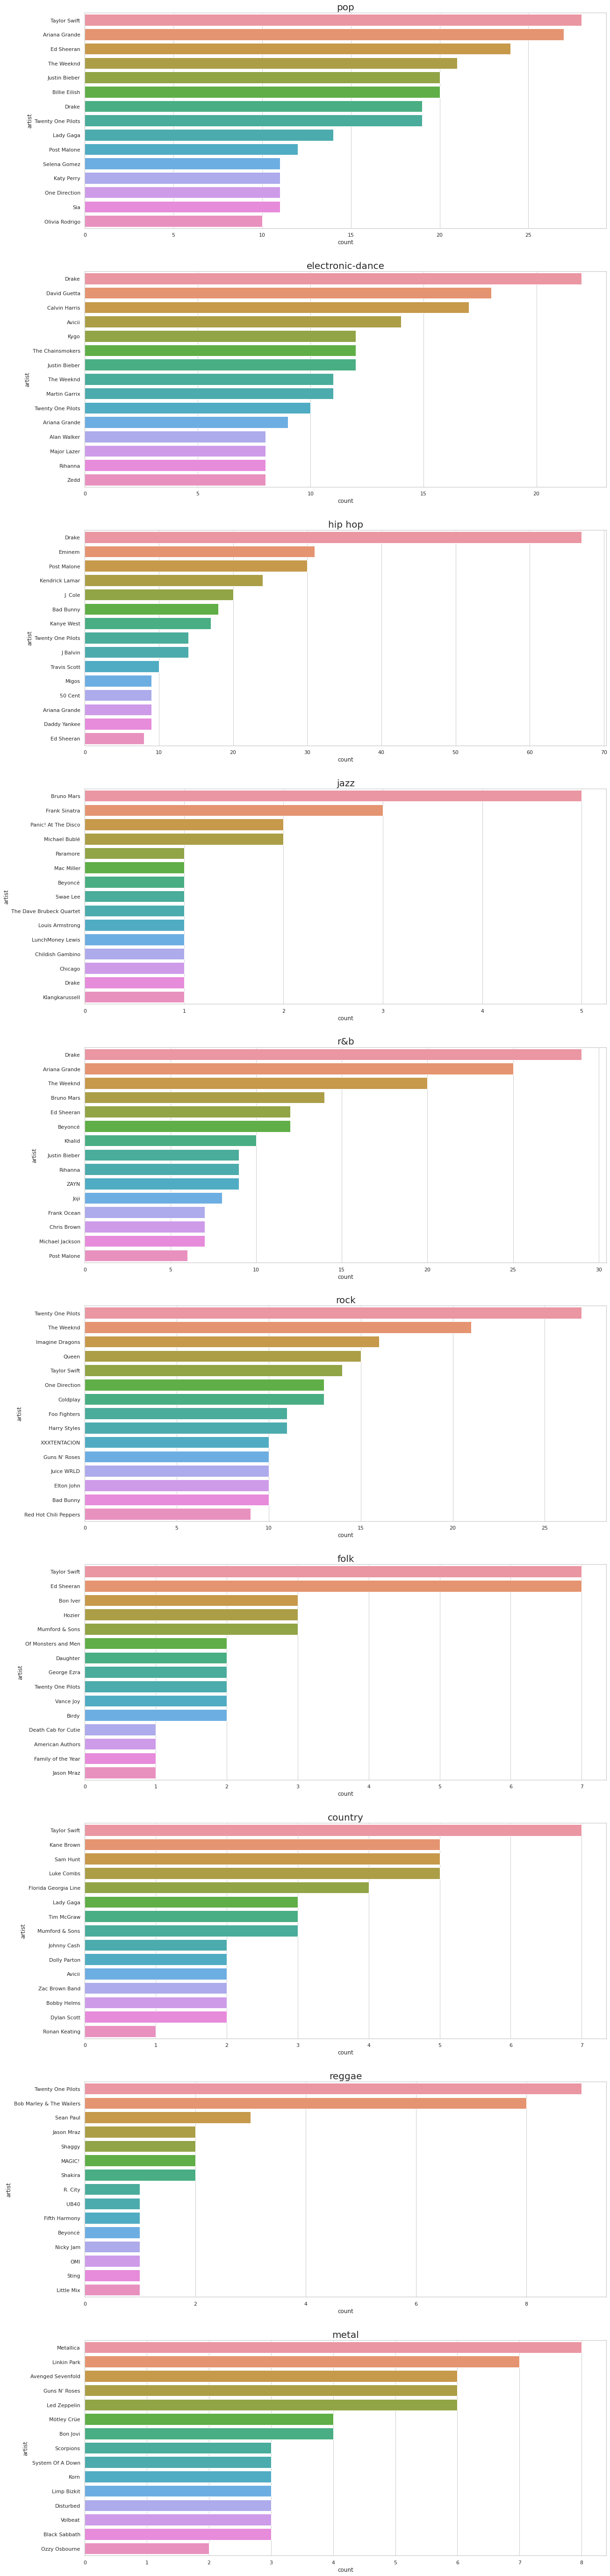

In [68]:
f, ax = plt.subplots(10, 1, figsize=(20, 100))
genres = df_with_genre["genres"].dropna().unique()
df_no_various_artist = df_with_genre[df_with_genre["artist"]
                                     != "Various Artists"]
for i, genre in enumerate(genres):
    data = df_no_various_artist[df_no_various_artist["genres"] == genre]
    sns.countplot(y="artist", data=data,
                  order=data['artist'].value_counts().index[0:15], ax=ax[i])
    ax[i].set_title(genre, fontsize=20)

In [106]:
sns.color_palette(palette='hls', n_colors=len(data['data'][0]['node']['color']))

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.4362, 0.33999999999999997),
 (0.86, 0.5012, 0.33999999999999997),
 (0.86, 0.5661999999999999, 0.33999999999999997),
 (0.86, 0.6312, 0.33999999999999997),
 (0.86, 0.6961999999999999, 0.33999999999999997),
 (0.86, 0.7612000000000001, 0.33999999999999997),
 (0.86, 0.8261999999999999, 0.33999999999999997),
 (0.8287999999999999, 0.86, 0.33999999999999997),
 (0.7638, 0.86, 0.33999999999999997),
 (0.6988, 0.86, 0.33999999999999997),
 (0.6337999999999998, 0.86, 0.33999999999999997),
 (0.5688000000000001, 0.86, 0.33999999999999997),
 (0.5038, 0.86, 0.33999999999999997),
 (0.43879999999999986, 0.86, 0.33999999999999997),
 (0.3738000000000001, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.3712),
 (0.33999999999999997, 0.86, 0.4361999999999999),
 (0.33999999999999997, 0.86, 0.5012000000000001),
 (0.33999999999999997, 0.86, 0.5662),
 (0.33999999999999997, 0.86, 0.6312),
 (0.33999999999999997, 0.86, 0.6962000000000002),
 (0.33999999999999997, 0.86, 0.7612000000000001),
 (0.33999999999999997, 0.86, 0.8261999999999999),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.33999999999999997, 0.7638, 0.86),
 (0.33999999999999997, 0.6988, 0.86),
 (0.33999999999999997, 0.6337999999999998, 0.86),
 (0.33999999999999997, 0.5688000000000001, 0.86),
 (0.33999999999999997, 0.5038, 0.86),
 (0.33999999999999997, 0.43879999999999986, 0.86),
 (0.33999999999999997, 0.3738000000000001, 0.86),
 (0.3712, 0.33999999999999997, 0.86),
 (0.43619999999999975, 0.33999999999999997, 0.86),
 (0.5011999999999995, 0.33999999999999997, 0.86),
 (0.5662, 0.33999999999999997, 0.86),
 (0.6311999999999998, 0.33999999999999997, 0.86),
 (0.6961999999999995, 0.33999999999999997, 0.86),
 (0.7612000000000001, 0.33999999999999997, 0.86),
 (0.8261999999999998, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.8287999999999999),
 (0.86, 0.33999999999999997, 0.7638),
 (0.86, 0.33999999999999997, 0.6987999999999996),
 (0.86, 0.33999999999999997, 0.6337999999999998),
 (0.86, 0.33999999999999997, 0.5688000000000001),
 (0.86, 0.33999999999999997, 0.5037999999999996),
 (0.86, 0.33999999999999997, 0.43879999999999986),
 (0.86, 0.33999999999999997, 0.3738000000000001)]

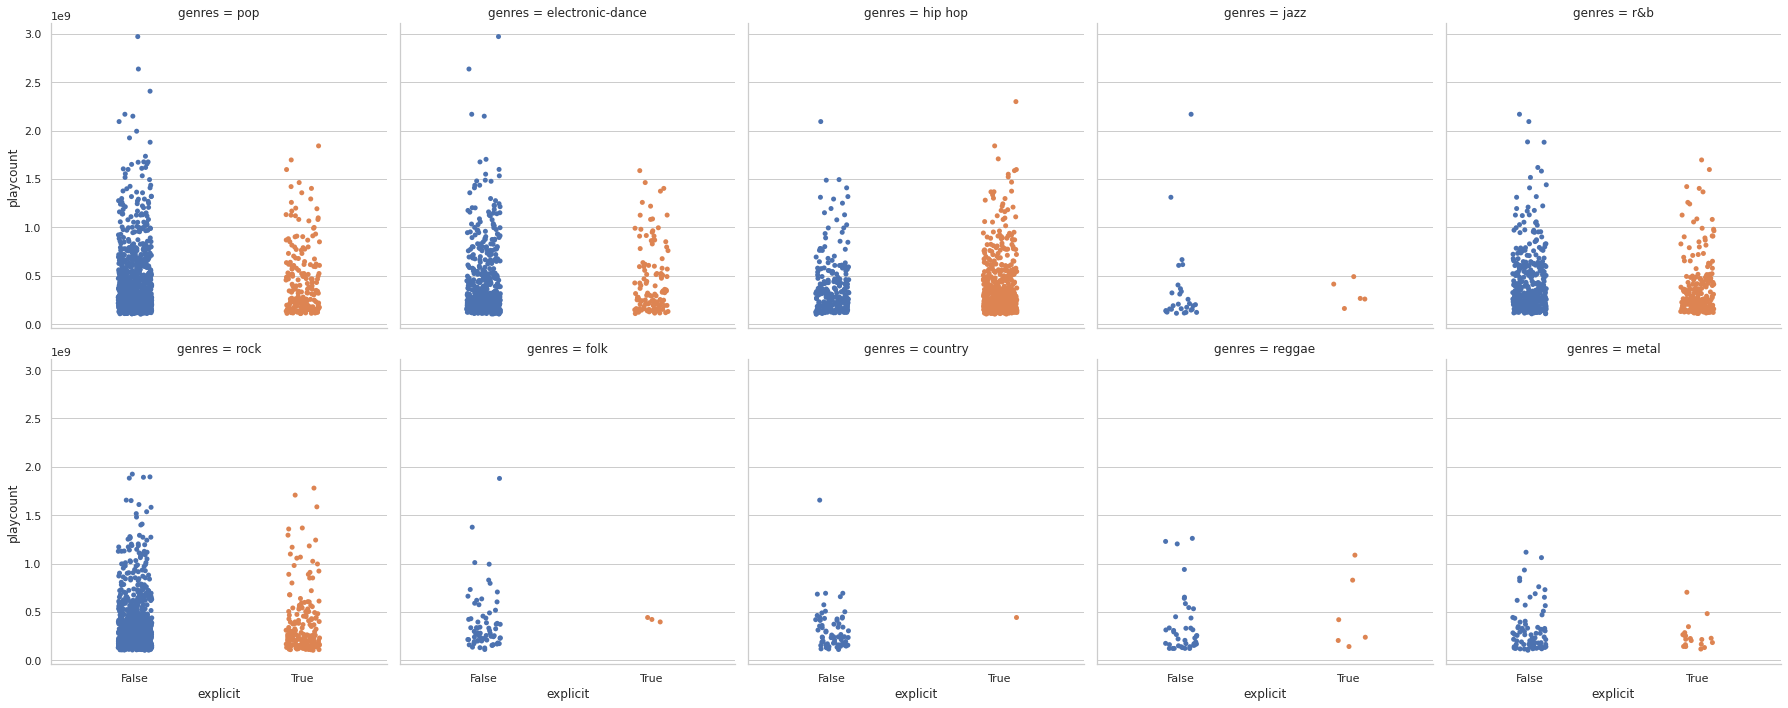

In [ ]:
sns.catplot(x="explicit", y="playcount",
            col="mode", data=df_with_genre, col_wrap=5)

<AxesSubplot:xlabel='genres', ylabel='view'>

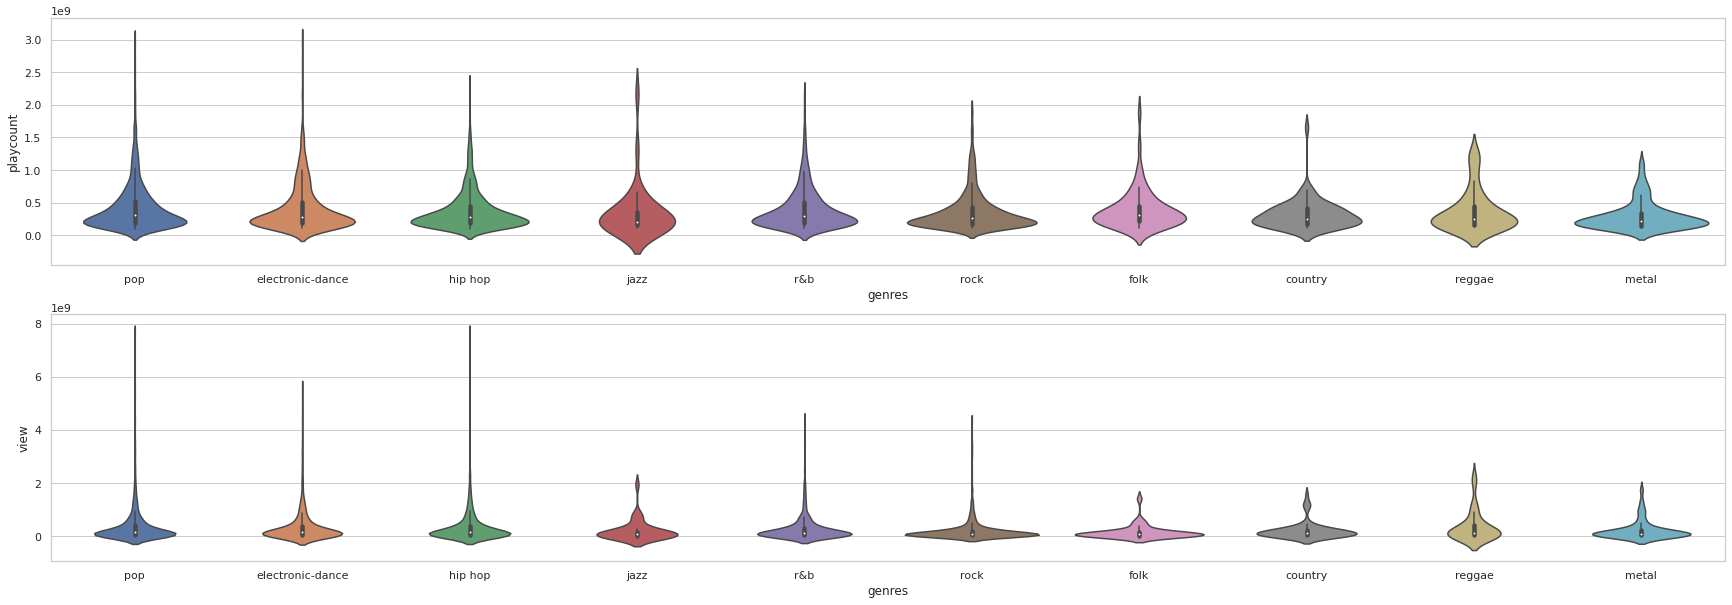

In [80]:
fig, ax = plt.subplots(2, 1, figsize=(30, 10))
sns.violinplot(x="genres", y="playcount", data=df_with_genre, ax=ax[0])
sns.violinplot(x="genres", y="view", data=df_with_genre, ax=ax[1])
